## SEIRS Model

**Problem description**:

The SEIRS model describes the spread of a disease in a population fixed to $N$ individuals over time $t$. Furthermore, the model divides the population into four categories, called "S", "E", "I", and "R". The extra "S" at the end usually means we include the loss of immunity.
- "S" consists of individuals who are susceptible to the disease being modeled.
- "E" consists of individuals who are exposed to the disease. Diseases (like COVID-19) often have an incubation period or a latency period and this category accommodates it. (The SIR model does not have this category.)
- "I" consists of individuals infected with the disease and are capable of infecting others.
- "R" consists of individuals who can be removed from the system, e.g., because they have gained immunity to the disease, or because they have succumbed to the disease.

The SEIR model, like many other epidemiological models depends on particular parameters, which are the following :
 - $\beta>0$ The rate of contraction of the disease (transmission parameter)
 - $ \sigma >0$ The incubation rate i.e. the rate at which exposed hosts become infected
 - $\gamma>0$ : The mean recovery rate
 - $\xi>0$ : The loss of immunity rate. 
 
Individual $S$ becomes infected after positive contact with an $I$ individual. However, he develops immunity to the disease : he leaves $I$ category at a $\gamma$ cure rate. However with a rate $\xi$, they may lose immunity to the disease and rejoin the susceptible population $S$.

**Model Assumptions**

- Model is deterministic
- On average, an individual $S$ in the population encounters $\beta$ individuals per unit time.
- The rate of infected individuals leaving category $I$ is $\gamma I$ per unit time (once an individual has been infected, he develops immunity to the disease).
- The population size $N=S+E+I+R$ is constant.
- Note constant average number of contacts $\beta$ is a strong and constraining assumption : it cannot be applied to all diseases.

This is the system of equations of the model :

The total population $N$ in the system (the sum of individuals in all categories) is likely to be quite large. Instead of working with such large numbers, let us divide each side of each equation by $\mathbf{N}$ and work instead with the proportions
$$
s=\frac{S}{N}, \quad e=\frac{E}{N}, \quad i=\frac{I}{N}, \quad r=\frac{R}{N} .
$$
The equivalent ODE system to be solved for the unknown functions $s(t), e(t), i(t)$, and $r(t)$, has now become
$$
\begin{aligned}
& \frac{d s}{d t}=-\beta i s  + \xi r\\
& \frac{d e}{d t}=\beta i s-\sigma e \\
& \frac{d i}{d t}=\sigma e-\gamma i \\
& \frac{d r}{d t}=\gamma i - \xi r
\end{aligned}
$$
When supplemented with some initial conditions, say
$$
s(0)=0.99, \quad e(0)=0.01, \quad i(0)=0, \quad r(0)=0
$$
This is the formulation of the Initial Value Probelm we wish to solve. Note that the above initial conditions correspond to a starting scenario where just $1 \%$ of the population is exposed.


In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import importlib
from pydci.examples import seirs
import pydci.consistent_bayes.OfflineSequential as os
import pydci.consistent_bayes.OfflineSequentialSearch as oss
from pydci.log import enable_log, disable_log, logger
from pydci.utils import get_l2_errs, set_seed

importlib.reload(seirs)

SEIRS_PARAM_MINS = 4 * [0]
SEIRS_STATE_MINS = 1e-10
SEIRS_STATE_MAXS = 1

# For periodic behavior
R_0 = 3

# Sample every week
SEIRS_SAMPLE_TS = 1

# Populations are all from 0-1 -> Fraction of population
SEIRS_NOISE = 0.001

# Parameters from bjornstad2020seirs paper
SEIRS_P1 = [
    R_0 / 14.0,  # beta transmission rate - R_0 / gamma -> R_0 > 0 for periodic behavior
    1.0
    / 7.0,  # sigma incubation rate i.e. rate at which exposed hosts become infected - 1 week
    1.0 / 14.0,  # gamma  mean recovery rate - 2 weeks
    1.0 / 365.0,  # xi - loss off imunity rate - 1 year
]

# (1) Policy Lockdown 1 month in: => Slower Transmission Rate(beta) - Time 75
SEIRS_P2 = [
    0.5 * R_0 / 14.0,  # transmission rate halved
    1.0 / 7.0,  # sigm
    1.0 / 14.0,
    1.0 / 365.0,
]
# (2) Virus Mutation 1 year in: => Faster Incubation Rate (sigma) - Time 150
SEIRS_P3 = [
    1.2 * R_0 / 14.0,  # transmission rate increased -> Faster transmitting virus
    1.0 / 3.5,  # Incubation rate halved -> Exposed hosts become infected quicker
    1.0 / 14.0,
    1.0 / 365.0,
]

SEIRS_X0 = [
    0.98,  # susceptible
    0.010,  # exposed
    0.010,  # infected
    0,  # recovered
]

# Uniform over range +- 1* true values
SEIRS_DEF_INIT = [
    "uniform",
    {"scale": 1.0},
]

# enable_log(level='DEBUG')
n_samples = 1000
total_time = 1 * 365.25
param_shifts = {0: SEIRS_P1, 25: SEIRS_P2, 150: SEIRS_P3}

In [2]:
def solve_till_thresh(
    model,
    data_idx,
    exp_thresh=0.1,
    start_sample_size=100,
    max_sample_size=200,
    samples_inc=10,
    pi_in=None,
    sampling_args={},
    solve_args={},
    clear=False,
):
    """
    """
    data_idx = data_idx if data_idx != -1 else len(model.data) - 1
    if len(model.samples) <= data_idx or clear:
        # * First batch if not continuing from previous solve
        # * Or if clearing previous solve when clear = True
        pi_in, samples = model.get_initial_samples(
            num_samples=start_sample_size, **sampling_args
        )
        model.forward_solve(samples, append=False)

    sample_size = len(model.samples[data_idx])
    solved = False
    prob = None
    while not solved and sample_size < max_sample_size:
        logger.debug(f"Solving using {sample_size} samples")
        prob = oss.OfflineSequentialSearch(
            model.samples[data_idx],
            model.data[data_idx],
            model.measurement_noise,
            pi_in=pi_in,
        )
        solve_args['exp_thresh'] = exp_thresh
        try:
            prob.solve(**solve_args)
        except RuntimeError as r:
            logger.debug(f"Failed: {r}")
            logger.debug(f"Drawing {samples_inc} more samples.")
            _, samples = model.get_initial_samples(
                num_samples=samples_inc, **sampling_args)
            sample_size += samples_inc
            logger.debug(f"Solving forward model for {samples_inc} more samples")
            model.forward_solve(samples, append=True)
        else:
            solved = True
        
    return prob

## Problem Set-Up

[08/08/23 12:27:06] INFO     Logger initialized                                                           ]8;id=749590;file:///Users/carlos/repos/pyDCI/src/pydci/log.py\log.py]8;;\:]8;id=892500;file:///Users/carlos/repos/pyDCI/src/pydci/log.py#80\80]8;;\

                    DEBUG    State idxs set at 1 of 4 total indices                                     ]8;id=974004;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=240504;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#99\99]8;;\

                    INFO     Getting data for model from 0 to 365.25                                   ]8;id=944087;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=321836;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#354\354]8;;\

                    DEBUG    Shapes: (3652, 1), (3652, 4), (3652,)                                     ]8;id=740966;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=497137;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#369\369]8;;\

<AxesSubplot: title={'center': 'Infected Population'}, xlabel='Days', ylabel='Fraction of Population'>

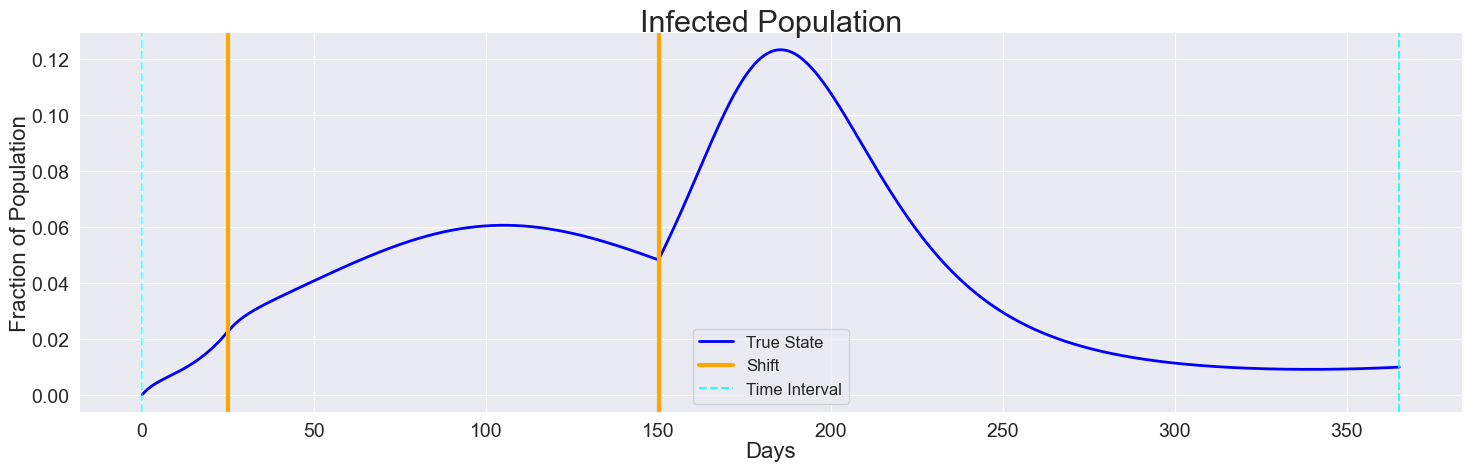

In [3]:
enable_log(level="DEBUG")
full_sr = seirs.SEIRSModel(
    lam_true=SEIRS_P1,
    param_shifts=param_shifts,
    measurement_noise=SEIRS_NOISE,
    sample_ts=SEIRS_SAMPLE_TS,
    state_mins=SEIRS_STATE_MINS,
    state_maxs=SEIRS_STATE_MAXS,
    def_init=SEIRS_DEF_INIT,
)

# pi_in, samples = full_sr.get_uniform_initial_samples(num_samples=1, scale=0.1)
res = full_sr.get_data(t0=0, tf=total_time)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
full_sr.plot_infected(plot_samples=False, plot_measurements=False, ax=ax)

# Online Iteartive - Algorithm Breakdowns

- Use fixed chunks of data, and a fixed set of "search" parameters per chunk of data
- Always re-sample between chunks of data.
- "Search" parameter determine the sets of solution parameters to use for each chunk when trying to solve the problem.
- Search params can vary the:

    1. \# of principal components
    2. \# of splits to use on the chunk of data, for doing offline iterative estimation.
    3. \# of total data points to use, i.e. whether to only use a fraction of the data chunk.


In [4]:
total_time = 1 * 365.25
max_nc = 1
data_chunk_size = 7
n_chunks = int(total_time / data_chunk_size)

sr = seirs.SEIRSModel(
    lam_true=SEIRS_P1,
    param_shifts=param_shifts,
    measurement_noise=SEIRS_NOISE,
    sample_ts=SEIRS_SAMPLE_TS,
    state_mins=SEIRS_STATE_MINS,
    state_maxs=SEIRS_STATE_MAXS,
    def_init=SEIRS_DEF_INIT,
)

[08/08/23 12:27:07] DEBUG    State idxs set at 1 of 4 total indices                                     ]8;id=459835;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=873253;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#99\99]8;;\

## Step by step - Frist 5 Iterations Breakdown

In [5]:
probs = []
n_samples = 100
e_r_thresh = 0.1

### Frist Iteration

Note we can retry the block below if the next solve fails, adding more samples to the problem.

In [6]:
# enable_log(level='DEBUG')
disable_log()

try:
    sr.get_data(tf=7)
except ValueError as v:
    print(v)

In [7]:
enable_log(level='DEBUG')
prob_1 = solve_till_thresh(
    sr,
    0,
    exp_thresh=0.2,
    start_sample_size=10,
    max_sample_size=300,
    samples_inc=20,
    pi_in=None,
    sampling_args={'scale': 1.0},
    solve_args={'exp_thresh': 1e10, 'best_method': 'max_kl'},
)

[08/08/23 12:27:09] INFO     Logger initialized                                                           ]8;id=565208;file:///Users/carlos/repos/pyDCI/src/pydci/log.py\log.py]8;;\:]8;id=544950;file:///Users/carlos/repos/pyDCI/src/pydci/log.py#80\80]8;;\

                    INFO     Drawing 10 from uniform at:                                               ]8;id=279230;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=49718;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#543\543]8;;\
                                     loc: [0. 0. 0. 0.]                                                            
                                     scale: [0.42857143 0.28571429 0.14285714 0.00547945]                          

                    INFO     Beginning forward solve from 0.0 to 7.0                                   ]8;id=188515;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=64790;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#422\422]8;;\

                    DEBUG    Starting fresh simulation for 10                                          ]8;id=771985;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=975320;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#433\433]8;;\

                    DEBUG    Solving using 10 samples                                              ]8;id=51757;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py\2298686082.py]8;;\:]8;id=603345;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py#28\28]8;;\

                    INFO     Searching through combinations:                         ]8;id=913405;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=824480;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#171\171]8;;\
                                  exp_thresh pca_components                                                        
                             pca_mask  pca_splits                                                                  
                             0  1.000000e+10          [[0]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           1                                                                        
                             1  1.000000e+10          [[0]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           2                                                                        
                             2  1.000000e+10       [[0, 1]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           1                                                                        
                             3  1.000000e+10       [[0, 1]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           2                                                                        

                    DEBUG    Attempting solve with args: {'exp_thresh': 0.2,         ]8;id=999994;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=151141;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#215\215]8;;\
                             'pca_components': [[0]], 'pca_mask': range(0, 8),                                     
                             'pca_splits': 1, 'fail_on_partial': True}                                             

Solving for different combinations |                                        | ▁▃

                    INFO     Iteration 0: Solving using (range(0, 8), [0])                 ]8;id=929613;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=366708;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#191\191]8;;\

                    DEBUG    Computing PCA using 4 components                                  ]8;id=98332;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=340570;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#146\146]8;;\

                    DEBUG    PCA Variance: [8.24995090e+00 5.15046652e-01 1.23599673e-01       ]8;id=803642;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=393073;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#155\155]8;;\
                             2.90505275e-04]                                                                       

                    DEBUG    Calculating pi_pr by computing KDE on q_lam                          ]8;id=813394;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=431534;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#213\213]8;;\

                    INFO     |E(r) - 1| = 0.20954916437446092 > 0.2 - Stopping             ]8;id=72838;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=807281;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#228\228]8;;\

                    ERROR    Failed: No solution in exp_thresh: No solution found    ]8;id=74888;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=756555;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#222\222]8;;\
                             within exp_thresh                                                                     

Solving for different combinations |⚠︎                                       | (!


[08/08/23 12:27:10] DEBUG    Failed: No solution found within exp_thresh                           ]8;id=264504;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py\2298686082.py]8;;\:]8;id=907820;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py#39\39]8;;\

                    DEBUG    Drawing 20 more samples.                                              ]8;id=37381;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py\2298686082.py]8;;\:]8;id=612201;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py#40\40]8;;\

                    INFO     Drawing 20 from uniform at:                                               ]8;id=59375;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=507621;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#543\543]8;;\
                                     loc: [0. 0. 0. 0.]                                                            
                                     scale: [0.42857143 0.28571429 0.14285714 0.00547945]                          

                    DEBUG    Solving forward model for 20 more samples                             ]8;id=111345;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py\2298686082.py]8;;\:]8;id=263869;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py#44\44]8;;\

                    INFO     Beginning forward solve from 0.0 to 7.0                                   ]8;id=203878;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=32102;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#422\422]8;;\

                    DEBUG    Starting fresh simulation for 20                                          ]8;id=425630;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=4492;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#433\433]8;;\

                    DEBUG    Solving using 30 samples                                              ]8;id=999191;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py\2298686082.py]8;;\:]8;id=277176;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py#28\28]8;;\

                    INFO     Searching through combinations:                         ]8;id=536762;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=639518;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#171\171]8;;\
                                  exp_thresh pca_components                                                        
                             pca_mask  pca_splits                                                                  
                             0  1.000000e+10          [[0]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           1                                                                        
                             1  1.000000e+10          [[0]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           2                                                                        
                             2  1.000000e+10       [[0, 1]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           1                                                                        
                             3  1.000000e+10       [[0, 1]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           2                                                                        

Solving for different combinations |                                        | ▁▃

                    DEBUG    Attempting solve with args: {'exp_thresh': 0.2,         ]8;id=878610;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=358744;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#215\215]8;;\
                             'pca_components': [[0]], 'pca_mask': range(0, 8),                                     
                             'pca_splits': 1, 'fail_on_partial': True}                                             

                    INFO     Iteration 0: Solving using (range(0, 8), [0])                 ]8;id=82550;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=10381;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#191\191]8;;\

                    DEBUG    Computing PCA using 4 components                                  ]8;id=813671;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=795536;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#146\146]8;;\

                    DEBUG    PCA Variance: [7.63325107e+00 5.24106221e-01 1.17744686e-01       ]8;id=265223;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=68181;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#155\155]8;;\
                             7.52749053e-04]                                                                       

                    DEBUG    Calculating pi_pr by computing KDE on q_lam                          ]8;id=892664;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=792616;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#213\213]8;;\

                    INFO     |E(r) - 1| = 0.4250543872359944 > 0.2 - Stopping              ]8;id=891366;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=505099;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#228\228]8;;\

                    ERROR    Failed: No solution in exp_thresh: No solution found    ]8;id=138120;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=356539;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#222\222]8;;\
                             within exp_thresh                                                                     

Solving for different combinations |⚠︎                                       | (!


                    DEBUG    Failed: No solution found within exp_thresh                           ]8;id=517683;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py\2298686082.py]8;;\:]8;id=355764;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py#39\39]8;;\

                    DEBUG    Drawing 20 more samples.                                              ]8;id=102704;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py\2298686082.py]8;;\:]8;id=426109;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py#40\40]8;;\

                    INFO     Drawing 20 from uniform at:                                               ]8;id=868240;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=252011;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#543\543]8;;\
                                     loc: [0. 0. 0. 0.]                                                            
                                     scale: [0.42857143 0.28571429 0.14285714 0.00547945]                          

                    DEBUG    Solving forward model for 20 more samples                             ]8;id=898312;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py\2298686082.py]8;;\:]8;id=36042;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py#44\44]8;;\

                    INFO     Beginning forward solve from 0.0 to 7.0                                   ]8;id=106601;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=986399;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#422\422]8;;\

                    DEBUG    Starting fresh simulation for 20                                          ]8;id=86429;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=107974;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#433\433]8;;\

                    DEBUG    Solving using 50 samples                                              ]8;id=895565;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py\2298686082.py]8;;\:]8;id=345601;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py#28\28]8;;\

                    INFO     Searching through combinations:                         ]8;id=436010;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=446188;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#171\171]8;;\
                                  exp_thresh pca_components                                                        
                             pca_mask  pca_splits                                                                  
                             0  1.000000e+10          [[0]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           1                                                                        
                             1  1.000000e+10          [[0]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           2                                                                        
                             2  1.000000e+10       [[0, 1]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           1                                                                        
                             3  1.000000e+10       [[0, 1]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           2                                                                        

Solving for different combinations |                                        | ▁▃

                    DEBUG    Attempting solve with args: {'exp_thresh': 0.2,         ]8;id=130616;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=999431;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#215\215]8;;\
                             'pca_components': [[0]], 'pca_mask': range(0, 8),                                     
                             'pca_splits': 1, 'fail_on_partial': True}                                             

                    INFO     Iteration 0: Solving using (range(0, 8), [0])                 ]8;id=454170;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=958912;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#191\191]8;;\

                    DEBUG    Computing PCA using 4 components                                  ]8;id=153257;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=526828;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#146\146]8;;\

                    DEBUG    PCA Variance: [7.14643398e+00 8.86320727e-01 1.29369213e-01       ]8;id=820089;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=974612;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#155\155]8;;\
                             1.12801422e-03]                                                                       

                    DEBUG    Calculating pi_pr by computing KDE on q_lam                          ]8;id=490024;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=482131;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#213\213]8;;\

                    DEBUG    Attempting solve with args: {'exp_thresh': 0.2,         ]8;id=378864;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=794438;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#215\215]8;;\
                             'pca_components': [[0]], 'pca_mask': range(0, 8),                                     
                             'pca_splits': 2, 'fail_on_partial': True}                                             

                    INFO     Iteration 0: Solving using (range(0, 4), [0])                 ]8;id=343907;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=894286;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#191\191]8;;\

                    DEBUG    Computing PCA using 4 components                                  ]8;id=49842;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=130156;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#146\146]8;;\

                    DEBUG    PCA Variance: [3.36370672e+00 7.11865350e-01 6.03934812e-03       ]8;id=392382;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=287384;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#155\155]8;;\
                             2.12397932e-05]                                                                       

                    DEBUG    Calculating pi_pr by computing KDE on q_lam                          ]8;id=262620;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=515752;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#213\213]8;;\

                    INFO     Updating weights                                              ]8;id=272523;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=512167;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#257\257]8;;\

                    INFO     Iteration 1: Solving using (range(4, 8), [0])                 ]8;id=135347;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=180114;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#191\191]8;;\

                    DEBUG    Computing PCA using 4 components                                  ]8;id=702869;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=755729;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#146\146]8;;\

                    DEBUG    PCA Variance: [4.04859060e+00 3.29242307e-02 1.17293419e-04       ]8;id=593555;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=51097;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#155\155]8;;\
                             5.28132443e-07]                                                                       

Solving for different combinations |██████████                              | ▂▄

                    DEBUG    Calculating pi_in by computing KDE on lam                            ]8;id=919213;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=661031;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#187\187]8;;\

                    DEBUG    Calculating pi_pr by computing KDE on q_lam                          ]8;id=398472;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=673022;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#213\213]8;;\

                    INFO     |E(r) - 1| = 0.20705795374682245 > 0.2 - Stopping             ]8;id=901879;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=183677;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#228\228]8;;\

                    INFO     Resetting to last solution at (range(0, 4), [0])              ]8;id=250619;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=128639;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#234\234]8;;\

                    DEBUG    dists: {'pi_in':                                              ]8;id=20529;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=644404;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#237\237]8;;\
                             <scipy.stats._distn_infrastructure.rv_continuous_frozen                               
                             object at 0x16a24e750>, 'pi_pr':                                                      
                             <scipy.stats._kde.gaussian_kde object at 0x16a720b90>,                                
                             'pi_obs':                                                                             
                             <scipy.stats._distn_infrastructure.rv_continuous_frozen                               
                             object at 0x16a6f9990>, 'pi_up': None, 'pi_pf': None}                                 

                    INFO     Iteration 0: Solving using (range(0, 4), [0])                 ]8;id=944260;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=21484;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#191\191]8;;\

                    DEBUG    Computing PCA using 4 components                                  ]8;id=630591;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=286293;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#146\146]8;;\

                    DEBUG    PCA Variance: [3.36370672e+00 7.11865350e-01 6.03934812e-03       ]8;id=833690;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=579;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#155\155]8;;\
                             2.12397932e-05]                                                                       

                    DEBUG    Calculating pi_pr by computing KDE on q_lam                          ]8;id=911967;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=741953;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#213\213]8;;\

                    ERROR    Failed: No solution found for all data: Failed to solve ]8;id=900852;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=539075;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#225\225]8;;\
                             problem through all iterations                                                        

                    DEBUG    Attempting solve with args: {'exp_thresh': 0.2,         ]8;id=512389;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=49631;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#215\215]8;;\
                             'pca_components': [[0, 1]], 'pca_mask': range(0, 8),                                  
                             'pca_splits': 1, 'fail_on_partial': True}                                             

                    INFO     Iteration 0: Solving using (range(0, 8), [0, 1])              ]8;id=10882;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=112127;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#191\191]8;;\

                    DEBUG    Computing PCA using 4 components                                  ]8;id=956043;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=828697;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#146\146]8;;\

                    DEBUG    PCA Variance: [7.14643398e+00 8.86320727e-01 1.29369213e-01       ]8;id=820541;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=334835;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#155\155]8;;\
                             1.12801422e-03]                                                                       

                    DEBUG    Calculating pi_pr by computing KDE on q_lam                          ]8;id=341277;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=797530;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#213\213]8;;\

                    INFO     |E(r) - 1| = 0.40690861037852744 > 0.2 - Stopping             ]8;id=524390;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=513229;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#228\228]8;;\

                    ERROR    Failed: No solution in exp_thresh: No solution found    ]8;id=102593;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=987407;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#222\222]8;;\
                             within exp_thresh                                                                     

Solving for different combinations |████████████████████⚠︎                   | (!


                    DEBUG    Failed: No solution found within exp_thresh                           ]8;id=859597;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py\2298686082.py]8;;\:]8;id=403624;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py#39\39]8;;\

                    DEBUG    Drawing 20 more samples.                                              ]8;id=895429;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py\2298686082.py]8;;\:]8;id=90480;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py#40\40]8;;\

                    INFO     Drawing 20 from uniform at:                                               ]8;id=138681;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=25378;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#543\543]8;;\
                                     loc: [0. 0. 0. 0.]                                                            
                                     scale: [0.42857143 0.28571429 0.14285714 0.00547945]                          

                    DEBUG    Solving forward model for 20 more samples                             ]8;id=847602;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py\2298686082.py]8;;\:]8;id=275158;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py#44\44]8;;\

                    INFO     Beginning forward solve from 0.0 to 7.0                                   ]8;id=300529;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=353686;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#422\422]8;;\

                    DEBUG    Starting fresh simulation for 20                                          ]8;id=324880;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=524446;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#433\433]8;;\

                    DEBUG    Solving using 70 samples                                              ]8;id=49226;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py\2298686082.py]8;;\:]8;id=897307;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py#28\28]8;;\

                    INFO     Searching through combinations:                         ]8;id=208292;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=394262;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#171\171]8;;\
                                  exp_thresh pca_components                                                        
                             pca_mask  pca_splits                                                                  
                             0  1.000000e+10          [[0]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           1                                                                        
                             1  1.000000e+10          [[0]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           2                                                                        
                             2  1.000000e+10       [[0, 1]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           1                                                                        
                             3  1.000000e+10       [[0, 1]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           2                                                                        

                    DEBUG    Attempting solve with args: {'exp_thresh': 0.2,         ]8;id=613644;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=266618;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#215\215]8;;\
                             'pca_components': [[0]], 'pca_mask': range(0, 8),                                     
                             'pca_splits': 1, 'fail_on_partial': True}                                             

Solving for different combinations |                                        | ▁▃

                    INFO     Iteration 0: Solving using (range(0, 8), [0])                 ]8;id=696503;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=73904;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#191\191]8;;\

                    DEBUG    Computing PCA using 4 components                                  ]8;id=993667;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=869403;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#146\146]8;;\

                    DEBUG    PCA Variance: [7.29135989e+00 7.15599783e-01 1.07936078e-01       ]8;id=241756;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=478694;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#155\155]8;;\
                             1.03567232e-03]                                                                       

                    DEBUG    Calculating pi_pr by computing KDE on q_lam                          ]8;id=133969;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=890324;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#213\213]8;;\

                    DEBUG    Attempting solve with args: {'exp_thresh': 0.2,         ]8;id=18341;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=586791;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#215\215]8;;\
                             'pca_components': [[0]], 'pca_mask': range(0, 8),                                     
                             'pca_splits': 2, 'fail_on_partial': True}                                             

                    INFO     Iteration 0: Solving using (range(0, 4), [0])                 ]8;id=384602;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=651272;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#191\191]8;;\

                    DEBUG    Computing PCA using 4 components                                  ]8;id=332041;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=673979;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#146\146]8;;\

                    DEBUG    PCA Variance: [3.49883869e+00 5.53988623e-01 5.12507219e-03       ]8;id=266849;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=109989;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#155\155]8;;\
                             1.86329631e-05]                                                                       

                    DEBUG    Calculating pi_pr by computing KDE on q_lam                          ]8;id=41673;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=448017;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#213\213]8;;\

                    INFO     Updating weights                                              ]8;id=267860;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=394069;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#257\257]8;;\

                    INFO     Iteration 1: Solving using (range(4, 8), [0])                 ]8;id=584836;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=420824;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#191\191]8;;\

                    DEBUG    Computing PCA using 4 components                                  ]8;id=349013;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=832156;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#146\146]8;;\

                    DEBUG    PCA Variance: [4.03007485e+00 2.78060520e-02 8.96021801e-05       ]8;id=512071;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=525565;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#155\155]8;;\
                             5.11633075e-07]                                                                       

                    DEBUG    Calculating pi_in by computing KDE on lam                            ]8;id=829093;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=376752;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#187\187]8;;\

                    DEBUG    Calculating pi_pr by computing KDE on q_lam                          ]8;id=388638;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=329792;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#213\213]8;;\

                    DEBUG    Attempting solve with args: {'exp_thresh': 0.2,         ]8;id=749867;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=978031;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#215\215]8;;\
                             'pca_components': [[0, 1]], 'pca_mask': range(0, 8),                                  
                             'pca_splits': 1, 'fail_on_partial': True}                                             

                    INFO     Iteration 0: Solving using (range(0, 8), [0, 1])              ]8;id=627568;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=245884;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#191\191]8;;\

                    DEBUG    Computing PCA using 4 components                                  ]8;id=357401;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=295510;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#146\146]8;;\

                    DEBUG    PCA Variance: [7.29135989e+00 7.15599783e-01 1.07936078e-01       ]8;id=77158;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=955376;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#155\155]8;;\
                             1.03567232e-03]                                                                       

                    DEBUG    Calculating pi_pr by computing KDE on q_lam                          ]8;id=376116;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=594760;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#213\213]8;;\

                    INFO     |E(r) - 1| = 0.4656993966729345 > 0.2 - Stopping              ]8;id=825611;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=673523;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#228\228]8;;\

                    ERROR    Failed: No solution in exp_thresh: No solution found    ]8;id=703632;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=270385;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#222\222]8;;\
                             within exp_thresh                                                                     

Solving for different combinations |████████████████████⚠︎                   | (!


                    DEBUG    Failed: No solution found within exp_thresh                           ]8;id=211100;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py\2298686082.py]8;;\:]8;id=300896;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py#39\39]8;;\

                    DEBUG    Drawing 20 more samples.                                              ]8;id=229293;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py\2298686082.py]8;;\:]8;id=645276;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py#40\40]8;;\

                    INFO     Drawing 20 from uniform at:                                               ]8;id=627040;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=348331;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#543\543]8;;\
                                     loc: [0. 0. 0. 0.]                                                            
                                     scale: [0.42857143 0.28571429 0.14285714 0.00547945]                          

                    DEBUG    Solving forward model for 20 more samples                             ]8;id=952684;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py\2298686082.py]8;;\:]8;id=11138;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py#44\44]8;;\

                    INFO     Beginning forward solve from 0.0 to 7.0                                   ]8;id=947938;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=713703;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#422\422]8;;\

                    DEBUG    Starting fresh simulation for 20                                          ]8;id=926182;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=119117;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#433\433]8;;\

                    DEBUG    Solving using 90 samples                                              ]8;id=682101;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py\2298686082.py]8;;\:]8;id=363428;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py#28\28]8;;\

                    INFO     Searching through combinations:                         ]8;id=924021;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=905766;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#171\171]8;;\
                                  exp_thresh pca_components                                                        
                             pca_mask  pca_splits                                                                  
                             0  1.000000e+10          [[0]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           1                                                                        
                             1  1.000000e+10          [[0]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           2                                                                        
                             2  1.000000e+10       [[0, 1]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           1                                                                        
                             3  1.000000e+10       [[0, 1]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           2                                                                        

Solving for different combinations |                                        | ▁▃

                    DEBUG    Attempting solve with args: {'exp_thresh': 0.2,         ]8;id=626946;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=745967;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#215\215]8;;\
                             'pca_components': [[0]], 'pca_mask': range(0, 8),                                     
                             'pca_splits': 1, 'fail_on_partial': True}                                             

                    INFO     Iteration 0: Solving using (range(0, 8), [0])                 ]8;id=679062;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=910096;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#191\191]8;;\

                    DEBUG    Computing PCA using 4 components                                  ]8;id=316046;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=998184;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#146\146]8;;\

                    DEBUG    PCA Variance: [7.16690257e+00 8.09281787e-01 1.12471793e-01       ]8;id=928502;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=614847;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#155\155]8;;\
                             1.22078167e-03]                                                                       

                    DEBUG    Calculating pi_pr by computing KDE on q_lam                          ]8;id=306342;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=557015;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#213\213]8;;\

                    DEBUG    Attempting solve with args: {'exp_thresh': 0.2,         ]8;id=135647;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=231739;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#215\215]8;;\
                             'pca_components': [[0]], 'pca_mask': range(0, 8),                                     
                             'pca_splits': 2, 'fail_on_partial': True}                                             

                    INFO     Iteration 0: Solving using (range(0, 4), [0])                 ]8;id=470036;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=509869;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#191\191]8;;\

                    DEBUG    Computing PCA using 4 components                                  ]8;id=736909;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=71808;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#146\146]8;;\

                    DEBUG    PCA Variance: [3.44606917e+00 5.93516762e-01 5.33488938e-03       ]8;id=511912;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=735110;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#155\155]8;;\
                             2.29960897e-05]                                                                       

                    DEBUG    Calculating pi_pr by computing KDE on q_lam                          ]8;id=892679;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=115062;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#213\213]8;;\

                    INFO     Updating weights                                              ]8;id=503147;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=821494;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#257\257]8;;\

                    INFO     Iteration 1: Solving using (range(4, 8), [0])                 ]8;id=290011;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=28271;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#191\191]8;;\

                    DEBUG    Computing PCA using 4 components                                  ]8;id=925328;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=604609;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#146\146]8;;\

                    DEBUG    PCA Variance: [4.01329053e+00 3.15608625e-02 9.18419875e-05       ]8;id=122282;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=634517;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#155\155]8;;\
                             5.84699740e-07]                                                                       

                    DEBUG    Calculating pi_in by computing KDE on lam                            ]8;id=850990;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=586851;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#187\187]8;;\

                    DEBUG    Calculating pi_pr by computing KDE on q_lam                          ]8;id=493024;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=413549;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#213\213]8;;\

                    DEBUG    Attempting solve with args: {'exp_thresh': 0.2,         ]8;id=285392;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=387901;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#215\215]8;;\
                             'pca_components': [[0, 1]], 'pca_mask': range(0, 8),                                  
                             'pca_splits': 1, 'fail_on_partial': True}                                             

[08/08/23 12:27:11] INFO     Iteration 0: Solving using (range(0, 8), [0, 1])              ]8;id=198531;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=688303;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#191\191]8;;\

                    DEBUG    Computing PCA using 4 components                                  ]8;id=520000;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=543660;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#146\146]8;;\

                    DEBUG    PCA Variance: [7.16690257e+00 8.09281787e-01 1.12471793e-01       ]8;id=605936;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=807136;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#155\155]8;;\
                             1.22078167e-03]                                                                       

                    DEBUG    Calculating pi_pr by computing KDE on q_lam                          ]8;id=265450;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=401308;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#213\213]8;;\

                    INFO     |E(r) - 1| = 0.4437069414593089 > 0.2 - Stopping              ]8;id=540355;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=359396;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#228\228]8;;\

Solving for different combinations |████████████████████                    | ▂▄

                    ERROR    Failed: No solution in exp_thresh: No solution found    ]8;id=909332;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=830137;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#222\222]8;;\
                             within exp_thresh                                                                     

Solving for different combinations |████████████████████⚠︎                   | (!


                    DEBUG    Failed: No solution found within exp_thresh                           ]8;id=144836;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py\2298686082.py]8;;\:]8;id=86213;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py#39\39]8;;\

                    DEBUG    Drawing 20 more samples.                                              ]8;id=89343;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py\2298686082.py]8;;\:]8;id=383306;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py#40\40]8;;\

                    INFO     Drawing 20 from uniform at:                                               ]8;id=43954;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=42868;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#543\543]8;;\
                                     loc: [0. 0. 0. 0.]                                                            
                                     scale: [0.42857143 0.28571429 0.14285714 0.00547945]                          

                    DEBUG    Solving forward model for 20 more samples                             ]8;id=812596;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py\2298686082.py]8;;\:]8;id=733329;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py#44\44]8;;\

                    INFO     Beginning forward solve from 0.0 to 7.0                                   ]8;id=273881;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=2090;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#422\422]8;;\

                    DEBUG    Starting fresh simulation for 20                                          ]8;id=655447;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=106462;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#433\433]8;;\

                    DEBUG    Solving using 110 samples                                             ]8;id=324033;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py\2298686082.py]8;;\:]8;id=392803;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py#28\28]8;;\

                    INFO     Searching through combinations:                         ]8;id=780694;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=318567;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#171\171]8;;\
                                  exp_thresh pca_components                                                        
                             pca_mask  pca_splits                                                                  
                             0  1.000000e+10          [[0]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           1                                                                        
                             1  1.000000e+10          [[0]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           2                                                                        
                             2  1.000000e+10       [[0, 1]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           1                                                                        
                             3  1.000000e+10       [[0, 1]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           2                                                                        
                             4  1.000000e+10    [[0, 1, 2]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           1                                                                        
                             5  1.000000e+10    [[0, 1, 2]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           2                                                                        

                    DEBUG    Attempting solve with args: {'exp_thresh': 0.2,         ]8;id=697858;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=877849;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#215\215]8;;\
                             'pca_components': [[0]], 'pca_mask': range(0, 8),                                     
                             'pca_splits': 1, 'fail_on_partial': True}                                             

                    INFO     Iteration 0: Solving using (range(0, 8), [0])                 ]8;id=827836;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=670566;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#191\191]8;;\

                    DEBUG    Computing PCA using 4 components                                  ]8;id=620845;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=30761;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#146\146]8;;\

                    DEBUG    PCA Variance: [7.17884442e+00 7.89451774e-01 1.03737799e-01       ]8;id=721320;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=292837;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#155\155]8;;\
                             1.35041113e-03]                                                                       

Solving for different combinations |                                        | ▁▃

                    DEBUG    Calculating pi_pr by computing KDE on q_lam                          ]8;id=21531;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=794466;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#213\213]8;;\

                    DEBUG    Attempting solve with args: {'exp_thresh': 0.2,         ]8;id=422169;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=585581;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#215\215]8;;\
                             'pca_components': [[0]], 'pca_mask': range(0, 8),                                     
                             'pca_splits': 2, 'fail_on_partial': True}                                             

                    INFO     Iteration 0: Solving using (range(0, 4), [0])                 ]8;id=515938;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=36189;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#191\191]8;;\

                    DEBUG    Computing PCA using 4 components                                  ]8;id=116657;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=430740;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#146\146]8;;\

                    DEBUG    PCA Variance: [3.45784907e+00 5.73972078e-01 4.84866230e-03       ]8;id=586839;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=850372;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#155\155]8;;\
                             2.74415219e-05]                                                                       

                    DEBUG    Calculating pi_pr by computing KDE on q_lam                          ]8;id=868534;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=537396;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#213\213]8;;\

                    INFO     Updating weights                                              ]8;id=352942;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=183789;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#257\257]8;;\

                    INFO     Iteration 1: Solving using (range(4, 8), [0])                 ]8;id=747925;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=952560;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#191\191]8;;\

                    DEBUG    Computing PCA using 4 components                                  ]8;id=918932;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=223775;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#146\146]8;;\

                    DEBUG    PCA Variance: [4.00722828e+00 2.93713114e-02 9.70773747e-05       ]8;id=79540;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=756236;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#155\155]8;;\
                             5.78385915e-07]                                                                       

                    DEBUG    Calculating pi_in by computing KDE on lam                            ]8;id=766454;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=818068;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#187\187]8;;\

                    DEBUG    Calculating pi_pr by computing KDE on q_lam                          ]8;id=557434;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=426226;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#213\213]8;;\

                    DEBUG    Attempting solve with args: {'exp_thresh': 0.2,         ]8;id=170024;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=830932;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#215\215]8;;\
                             'pca_components': [[0, 1]], 'pca_mask': range(0, 8),                                  
                             'pca_splits': 1, 'fail_on_partial': True}                                             

                    INFO     Iteration 0: Solving using (range(0, 8), [0, 1])              ]8;id=489488;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=265426;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#191\191]8;;\

                    DEBUG    Computing PCA using 4 components                                  ]8;id=587676;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=404699;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#146\146]8;;\

                    DEBUG    PCA Variance: [7.17884442e+00 7.89451774e-01 1.03737799e-01       ]8;id=794253;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=497073;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#155\155]8;;\
                             1.35041113e-03]                                                                       

                    DEBUG    Calculating pi_pr by computing KDE on q_lam                          ]8;id=83336;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=912966;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#213\213]8;;\

                    INFO     |E(r) - 1| = 0.3962929926889541 > 0.2 - Stopping              ]8;id=158403;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=408707;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#228\228]8;;\

                    ERROR    Failed: No solution in exp_thresh: No solution found    ]8;id=222956;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=368694;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#222\222]8;;\
                             within exp_thresh                                                                     

Solving for different combinations |█████████████▍⚠︎                         | (!


                    DEBUG    Failed: No solution found within exp_thresh                           ]8;id=132839;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py\2298686082.py]8;;\:]8;id=447664;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py#39\39]8;;\

                    DEBUG    Drawing 20 more samples.                                              ]8;id=440334;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py\2298686082.py]8;;\:]8;id=31153;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py#40\40]8;;\

                    INFO     Drawing 20 from uniform at:                                               ]8;id=502249;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=6885;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#543\543]8;;\
                                     loc: [0. 0. 0. 0.]                                                            
                                     scale: [0.42857143 0.28571429 0.14285714 0.00547945]                          

                    DEBUG    Solving forward model for 20 more samples                             ]8;id=33694;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py\2298686082.py]8;;\:]8;id=94572;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py#44\44]8;;\

                    INFO     Beginning forward solve from 0.0 to 7.0                                   ]8;id=309854;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=553305;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#422\422]8;;\

                    DEBUG    Starting fresh simulation for 20                                          ]8;id=138909;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=216148;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#433\433]8;;\

                    DEBUG    Solving using 130 samples                                             ]8;id=231243;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py\2298686082.py]8;;\:]8;id=277071;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py#28\28]8;;\

                    INFO     Searching through combinations:                         ]8;id=6345;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=344817;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#171\171]8;;\
                                  exp_thresh pca_components                                                        
                             pca_mask  pca_splits                                                                  
                             0  1.000000e+10          [[0]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           1                                                                        
                             1  1.000000e+10          [[0]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           2                                                                        
                             2  1.000000e+10       [[0, 1]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           1                                                                        
                             3  1.000000e+10       [[0, 1]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           2                                                                        
                             4  1.000000e+10    [[0, 1, 2]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           1                                                                        
                             5  1.000000e+10    [[0, 1, 2]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           2                                                                        

                    DEBUG    Attempting solve with args: {'exp_thresh': 0.2,         ]8;id=562491;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=55106;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#215\215]8;;\
                             'pca_components': [[0]], 'pca_mask': range(0, 8),                                     
                             'pca_splits': 1, 'fail_on_partial': True}                                             

                    INFO     Iteration 0: Solving using (range(0, 8), [0])                 ]8;id=439724;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=347213;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#191\191]8;;\

                    DEBUG    Computing PCA using 4 components                                  ]8;id=608103;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=94752;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#146\146]8;;\

                    DEBUG    PCA Variance: [7.11021782e+00 8.47137017e-01 1.03326981e-01       ]8;id=285238;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=781474;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#155\155]8;;\
                             1.32292603e-03]                                                                       

Solving for different combinations |                                        | ▁▃

                    DEBUG    Calculating pi_pr by computing KDE on q_lam                          ]8;id=639081;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=166834;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#213\213]8;;\

                    DEBUG    Attempting solve with args: {'exp_thresh': 0.2,         ]8;id=804161;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=889411;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#215\215]8;;\
                             'pca_components': [[0]], 'pca_mask': range(0, 8),                                     
                             'pca_splits': 2, 'fail_on_partial': True}                                             

                    INFO     Iteration 0: Solving using (range(0, 4), [0])                 ]8;id=235135;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=169626;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#191\191]8;;\

                    DEBUG    Computing PCA using 4 components                                  ]8;id=550917;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=127375;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#146\146]8;;\

                    DEBUG    PCA Variance: [3.42218836e+00 6.03967893e-01 4.82339293e-03       ]8;id=187423;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=883839;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#155\155]8;;\
                             2.81022074e-05]                                                                       

                    DEBUG    Calculating pi_pr by computing KDE on q_lam                          ]8;id=927123;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=756733;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#213\213]8;;\

                    INFO     Updating weights                                              ]8;id=499074;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=501023;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#257\257]8;;\

                    INFO     Iteration 1: Solving using (range(4, 8), [0])                 ]8;id=686553;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=889229;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#191\191]8;;\

                    DEBUG    Computing PCA using 4 components                                  ]8;id=615400;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=318287;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#146\146]8;;\

                    DEBUG    PCA Variance: [4.00044648e+00 3.04601159e-02 1.00573159e-04       ]8;id=447486;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=696605;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#155\155]8;;\
                             5.78911647e-07]                                                                       

                    DEBUG    Calculating pi_in by computing KDE on lam                            ]8;id=985327;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=315914;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#187\187]8;;\

                    DEBUG    Calculating pi_pr by computing KDE on q_lam                          ]8;id=390356;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=433565;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#213\213]8;;\

                    DEBUG    Attempting solve with args: {'exp_thresh': 0.2,         ]8;id=48703;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=472476;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#215\215]8;;\
                             'pca_components': [[0, 1]], 'pca_mask': range(0, 8),                                  
                             'pca_splits': 1, 'fail_on_partial': True}                                             

                    INFO     Iteration 0: Solving using (range(0, 8), [0, 1])              ]8;id=584649;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=181997;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#191\191]8;;\

                    DEBUG    Computing PCA using 4 components                                  ]8;id=699308;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=57269;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#146\146]8;;\

                    DEBUG    PCA Variance: [7.11021782e+00 8.47137017e-01 1.03326981e-01       ]8;id=983320;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=769410;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#155\155]8;;\
                             1.32292603e-03]                                                                       

                    DEBUG    Calculating pi_pr by computing KDE on q_lam                          ]8;id=790420;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=349115;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#213\213]8;;\

                    INFO     |E(r) - 1| = 0.2170556448231875 > 0.2 - Stopping              ]8;id=275175;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=193155;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#228\228]8;;\

                    ERROR    Failed: No solution in exp_thresh: No solution found    ]8;id=146940;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=760794;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#222\222]8;;\
                             within exp_thresh                                                                     

Solving for different combinations |█████████████▍⚠︎                         | (!


                    DEBUG    Failed: No solution found within exp_thresh                           ]8;id=769325;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py\2298686082.py]8;;\:]8;id=311345;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py#39\39]8;;\

                    DEBUG    Drawing 20 more samples.                                              ]8;id=373232;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py\2298686082.py]8;;\:]8;id=89696;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py#40\40]8;;\

                    INFO     Drawing 20 from uniform at:                                               ]8;id=993309;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=561647;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#543\543]8;;\
                                     loc: [0. 0. 0. 0.]                                                            
                                     scale: [0.42857143 0.28571429 0.14285714 0.00547945]                          

                    DEBUG    Solving forward model for 20 more samples                             ]8;id=222695;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py\2298686082.py]8;;\:]8;id=789370;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py#44\44]8;;\

                    INFO     Beginning forward solve from 0.0 to 7.0                                   ]8;id=139534;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=66849;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#422\422]8;;\

                    DEBUG    Starting fresh simulation for 20                                          ]8;id=780536;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=941998;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#433\433]8;;\

                    DEBUG    Solving using 150 samples                                             ]8;id=315879;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py\2298686082.py]8;;\:]8;id=375023;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py#28\28]8;;\

                    INFO     Searching through combinations:                         ]8;id=261375;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=580132;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#171\171]8;;\
                                  exp_thresh pca_components                                                        
                             pca_mask  pca_splits                                                                  
                             0  1.000000e+10          [[0]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           1                                                                        
                             1  1.000000e+10          [[0]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           2                                                                        
                             2  1.000000e+10       [[0, 1]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           1                                                                        
                             3  1.000000e+10       [[0, 1]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           2                                                                        
                             4  1.000000e+10    [[0, 1, 2]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           1                                                                        
                             5  1.000000e+10    [[0, 1, 2]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           2                                                                        

                    DEBUG    Attempting solve with args: {'exp_thresh': 0.2,         ]8;id=82489;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=339583;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#215\215]8;;\
                             'pca_components': [[0]], 'pca_mask': range(0, 8),                                     
                             'pca_splits': 1, 'fail_on_partial': True}                                             

                    INFO     Iteration 0: Solving using (range(0, 8), [0])                 ]8;id=898482;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=502195;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#191\191]8;;\

                    DEBUG    Computing PCA using 4 components                                  ]8;id=107548;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=4273;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#146\146]8;;\

Solving for different combinations |                                        | ▁▃

                    DEBUG    PCA Variance: [7.01660886e+00 9.20334342e-01 1.15266112e-01       ]8;id=858967;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=673939;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#155\155]8;;\
                             1.47103002e-03]                                                                       

                    DEBUG    Calculating pi_pr by computing KDE on q_lam                          ]8;id=732253;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=377093;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#213\213]8;;\

                    DEBUG    Attempting solve with args: {'exp_thresh': 0.2,         ]8;id=446313;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=600073;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#215\215]8;;\
                             'pca_components': [[0]], 'pca_mask': range(0, 8),                                     
                             'pca_splits': 2, 'fail_on_partial': True}                                             

                    INFO     Iteration 0: Solving using (range(0, 4), [0])                 ]8;id=161424;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=96637;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#191\191]8;;\

                    DEBUG    Computing PCA using 4 components                                  ]8;id=897512;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=774887;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#146\146]8;;\

                    DEBUG    PCA Variance: [3.35117619e+00 6.69914568e-01 5.72499181e-03       ]8;id=422606;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=756781;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#155\155]8;;\
                             2.98833587e-05]                                                                       

                    DEBUG    Calculating pi_pr by computing KDE on q_lam                          ]8;id=374296;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=485800;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#213\213]8;;\

                    INFO     Updating weights                                              ]8;id=811698;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=57893;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#257\257]8;;\

                    INFO     Iteration 1: Solving using (range(4, 8), [0])                 ]8;id=128230;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=570509;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#191\191]8;;\

                    DEBUG    Computing PCA using 4 components                                  ]8;id=546467;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=91658;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#146\146]8;;\

                    DEBUG    PCA Variance: [3.99393267e+00 3.28021021e-02 1.10281643e-04       ]8;id=688051;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=158166;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#155\155]8;;\
                             5.79415850e-07]                                                                       

                    DEBUG    Calculating pi_in by computing KDE on lam                            ]8;id=868861;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=516553;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#187\187]8;;\

                    DEBUG    Calculating pi_pr by computing KDE on q_lam                          ]8;id=669125;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=772445;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#213\213]8;;\

                    DEBUG    Attempting solve with args: {'exp_thresh': 0.2,         ]8;id=868343;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=522051;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#215\215]8;;\
                             'pca_components': [[0, 1]], 'pca_mask': range(0, 8),                                  
                             'pca_splits': 1, 'fail_on_partial': True}                                             

                    INFO     Iteration 0: Solving using (range(0, 8), [0, 1])              ]8;id=571696;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=46874;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#191\191]8;;\

                    DEBUG    Computing PCA using 4 components                                  ]8;id=928859;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=456164;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#146\146]8;;\

                    DEBUG    PCA Variance: [7.01660886e+00 9.20334342e-01 1.15266112e-01       ]8;id=468248;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=340471;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#155\155]8;;\
                             1.47103002e-03]                                                                       

                    DEBUG    Calculating pi_pr by computing KDE on q_lam                          ]8;id=550938;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=907587;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#213\213]8;;\

                    INFO     |E(r) - 1| = 0.24306529105279284 > 0.2 - Stopping             ]8;id=950607;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=354130;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#228\228]8;;\

                    ERROR    Failed: No solution in exp_thresh: No solution found    ]8;id=726048;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=4283;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#222\222]8;;\
                             within exp_thresh                                                                     

Solving for different combinations |█████████████▍⚠︎                         | (!


                    DEBUG    Failed: No solution found within exp_thresh                           ]8;id=901002;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py\2298686082.py]8;;\:]8;id=517405;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py#39\39]8;;\

                    DEBUG    Drawing 20 more samples.                                              ]8;id=535706;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py\2298686082.py]8;;\:]8;id=986478;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py#40\40]8;;\

                    INFO     Drawing 20 from uniform at:                                               ]8;id=768659;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=453117;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#543\543]8;;\
                                     loc: [0. 0. 0. 0.]                                                            
                                     scale: [0.42857143 0.28571429 0.14285714 0.00547945]                          

                    DEBUG    Solving forward model for 20 more samples                             ]8;id=576550;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py\2298686082.py]8;;\:]8;id=366856;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py#44\44]8;;\

                    INFO     Beginning forward solve from 0.0 to 7.0                                   ]8;id=801368;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=536911;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#422\422]8;;\

                    DEBUG    Starting fresh simulation for 20                                          ]8;id=690970;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=404889;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#433\433]8;;\

                    DEBUG    Solving using 170 samples                                             ]8;id=284311;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py\2298686082.py]8;;\:]8;id=940097;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py#28\28]8;;\

                    INFO     Searching through combinations:                         ]8;id=57189;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=455484;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#171\171]8;;\
                                  exp_thresh pca_components                                                        
                             pca_mask  pca_splits                                                                  
                             0  1.000000e+10          [[0]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           1                                                                        
                             1  1.000000e+10          [[0]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           2                                                                        
                             2  1.000000e+10       [[0, 1]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           1                                                                        
                             3  1.000000e+10       [[0, 1]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           2                                                                        
                             4  1.000000e+10    [[0, 1, 2]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           1                                                                        
                             5  1.000000e+10    [[0, 1, 2]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           2                                                                        

Solving for different combinations |                                        | ▁▃

[08/08/23 12:27:12] DEBUG    Attempting solve with args: {'exp_thresh': 0.2,         ]8;id=213880;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=54111;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#215\215]8;;\
                             'pca_components': [[0]], 'pca_mask': range(0, 8),                                     
                             'pca_splits': 1, 'fail_on_partial': True}                                             

                    INFO     Iteration 0: Solving using (range(0, 8), [0])                 ]8;id=281816;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=79388;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#191\191]8;;\

                    DEBUG    Computing PCA using 4 components                                  ]8;id=120755;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=430293;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#146\146]8;;\

                    DEBUG    PCA Variance: [7.01913183e+00 9.10972494e-01 1.15764380e-01       ]8;id=396733;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=209129;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#155\155]8;;\
                             1.45736101e-03]                                                                       

                    DEBUG    Calculating pi_pr by computing KDE on q_lam                          ]8;id=398563;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=626293;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#213\213]8;;\

                    DEBUG    Attempting solve with args: {'exp_thresh': 0.2,         ]8;id=383151;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=310698;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#215\215]8;;\
                             'pca_components': [[0]], 'pca_mask': range(0, 8),                                     
                             'pca_splits': 2, 'fail_on_partial': True}                                             

                    INFO     Iteration 0: Solving using (range(0, 4), [0])                 ]8;id=458874;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=765829;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#191\191]8;;\

                    DEBUG    Computing PCA using 4 components                                  ]8;id=151401;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=522208;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#146\146]8;;\

                    DEBUG    PCA Variance: [3.35445114e+00 6.63470533e-01 5.71730392e-03       ]8;id=412247;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=637192;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#155\155]8;;\
                             2.96659872e-05]                                                                       

                    DEBUG    Calculating pi_pr by computing KDE on q_lam                          ]8;id=399538;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=532115;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#213\213]8;;\

                    INFO     Updating weights                                              ]8;id=260475;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=74457;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#257\257]8;;\

                    INFO     Iteration 1: Solving using (range(4, 8), [0])                 ]8;id=171942;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=639972;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#191\191]8;;\

                    DEBUG    Computing PCA using 4 components                                  ]8;id=444582;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=496299;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#146\146]8;;\

                    DEBUG    PCA Variance: [3.99075968e+00 3.27979071e-02 1.10463581e-04       ]8;id=571010;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=348231;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#155\155]8;;\
                             5.88882411e-07]                                                                       

                    DEBUG    Calculating pi_in by computing KDE on lam                            ]8;id=829219;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=932156;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#187\187]8;;\

                    DEBUG    Calculating pi_pr by computing KDE on q_lam                          ]8;id=768423;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=947892;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#213\213]8;;\

                    DEBUG    Attempting solve with args: {'exp_thresh': 0.2,         ]8;id=807833;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=722311;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#215\215]8;;\
                             'pca_components': [[0, 1]], 'pca_mask': range(0, 8),                                  
                             'pca_splits': 1, 'fail_on_partial': True}                                             

                    INFO     Iteration 0: Solving using (range(0, 8), [0, 1])              ]8;id=232597;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=155803;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#191\191]8;;\

                    DEBUG    Computing PCA using 4 components                                  ]8;id=842064;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=716164;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#146\146]8;;\

                    DEBUG    PCA Variance: [7.01913183e+00 9.10972494e-01 1.15764380e-01       ]8;id=345972;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=767445;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#155\155]8;;\
                             1.45736101e-03]                                                                       

Solving for different combinations |██████▋                                 | ▂▄

                    DEBUG    Calculating pi_pr by computing KDE on q_lam                          ]8;id=485995;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=658250;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#213\213]8;;\

                    DEBUG    Attempting solve with args: {'exp_thresh': 0.2,         ]8;id=381538;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=940819;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#215\215]8;;\
                             'pca_components': [[0, 1]], 'pca_mask': range(0, 8),                                  
                             'pca_splits': 2, 'fail_on_partial': True}                                             

                    INFO     Iteration 0: Solving using (range(0, 4), [0, 1])              ]8;id=32220;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=953551;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#191\191]8;;\

                    DEBUG    Computing PCA using 4 components                                  ]8;id=433528;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=704333;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#146\146]8;;\

                    DEBUG    PCA Variance: [3.35445114e+00 6.63470533e-01 5.71730392e-03       ]8;id=984439;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=843322;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#155\155]8;;\
                             2.96659872e-05]                                                                       

                    DEBUG    Calculating pi_pr by computing KDE on q_lam                          ]8;id=647534;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=968853;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#213\213]8;;\

                    INFO     |E(r) - 1| = 0.2594026981594043 > 0.2 - Stopping              ]8;id=336977;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=554154;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#228\228]8;;\

                    ERROR    Failed: No solution in exp_thresh: No solution found    ]8;id=971676;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=481903;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#222\222]8;;\
                             within exp_thresh                                                                     

Solving for different combinations |████████████████████⚠︎                   | (!


                    DEBUG    Failed: No solution found within exp_thresh                           ]8;id=300818;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py\2298686082.py]8;;\:]8;id=141685;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py#39\39]8;;\

                    DEBUG    Drawing 20 more samples.                                              ]8;id=347086;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py\2298686082.py]8;;\:]8;id=214063;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py#40\40]8;;\

                    INFO     Drawing 20 from uniform at:                                               ]8;id=913040;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=676755;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#543\543]8;;\
                                     loc: [0. 0. 0. 0.]                                                            
                                     scale: [0.42857143 0.28571429 0.14285714 0.00547945]                          

                    DEBUG    Solving forward model for 20 more samples                             ]8;id=319333;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py\2298686082.py]8;;\:]8;id=147748;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py#44\44]8;;\

                    INFO     Beginning forward solve from 0.0 to 7.0                                   ]8;id=182286;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=72057;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#422\422]8;;\

                    DEBUG    Starting fresh simulation for 20                                          ]8;id=928962;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=573070;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#433\433]8;;\

                    DEBUG    Solving using 190 samples                                             ]8;id=283811;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py\2298686082.py]8;;\:]8;id=562280;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py#28\28]8;;\

                    INFO     Searching through combinations:                         ]8;id=769011;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=443850;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#171\171]8;;\
                                  exp_thresh pca_components                                                        
                             pca_mask  pca_splits                                                                  
                             0  1.000000e+10          [[0]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           1                                                                        
                             1  1.000000e+10          [[0]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           2                                                                        
                             2  1.000000e+10       [[0, 1]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           1                                                                        
                             3  1.000000e+10       [[0, 1]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           2                                                                        
                             4  1.000000e+10    [[0, 1, 2]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           1                                                                        
                             5  1.000000e+10    [[0, 1, 2]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           2                                                                        

Solving for different combinations |                                        | ▁▃

                    DEBUG    Attempting solve with args: {'exp_thresh': 0.2,         ]8;id=207504;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=886156;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#215\215]8;;\
                             'pca_components': [[0]], 'pca_mask': range(0, 8),                                     
                             'pca_splits': 1, 'fail_on_partial': True}                                             

                    INFO     Iteration 0: Solving using (range(0, 8), [0])                 ]8;id=382940;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=255707;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#191\191]8;;\

                    DEBUG    Computing PCA using 4 components                                  ]8;id=859616;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=825756;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#146\146]8;;\

                    DEBUG    PCA Variance: [6.94755959e+00 9.70919872e-01 1.22347761e-01       ]8;id=419460;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=721450;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#155\155]8;;\
                             1.48912541e-03]                                                                       

                    DEBUG    Calculating pi_pr by computing KDE on q_lam                          ]8;id=43976;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=883434;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#213\213]8;;\

                    DEBUG    Attempting solve with args: {'exp_thresh': 0.2,         ]8;id=869635;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=55319;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#215\215]8;;\
                             'pca_components': [[0]], 'pca_mask': range(0, 8),                                     
                             'pca_splits': 2, 'fail_on_partial': True}                                             

                    INFO     Iteration 0: Solving using (range(0, 4), [0])                 ]8;id=575431;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=695172;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#191\191]8;;\

                    DEBUG    Computing PCA using 4 components                                  ]8;id=280643;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=476431;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#146\146]8;;\

                    DEBUG    PCA Variance: [3.30171874e+00 7.13379085e-01 6.03516923e-03       ]8;id=164385;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=127846;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#155\155]8;;\
                             3.10237058e-05]                                                                       

                    DEBUG    Calculating pi_pr by computing KDE on q_lam                          ]8;id=393612;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=268092;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#213\213]8;;\

                    INFO     Updating weights                                              ]8;id=651422;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=341100;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#257\257]8;;\

                    INFO     Iteration 1: Solving using (range(4, 8), [0])                 ]8;id=779616;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=623591;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#191\191]8;;\

                    DEBUG    Computing PCA using 4 components                                  ]8;id=87157;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=385568;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#146\146]8;;\

                    DEBUG    PCA Variance: [3.98627937e+00 3.47669359e-02 1.17118653e-04       ]8;id=205922;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=952974;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#155\155]8;;\
                             5.95258876e-07]                                                                       

                    DEBUG    Calculating pi_in by computing KDE on lam                            ]8;id=921998;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=830236;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#187\187]8;;\

                    DEBUG    Calculating pi_pr by computing KDE on q_lam                          ]8;id=596745;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=316403;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#213\213]8;;\

                    DEBUG    Attempting solve with args: {'exp_thresh': 0.2,         ]8;id=531619;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=815237;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#215\215]8;;\
                             'pca_components': [[0, 1]], 'pca_mask': range(0, 8),                                  
                             'pca_splits': 1, 'fail_on_partial': True}                                             

                    INFO     Iteration 0: Solving using (range(0, 8), [0, 1])              ]8;id=240657;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=844854;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#191\191]8;;\

                    DEBUG    Computing PCA using 4 components                                  ]8;id=226938;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=973069;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#146\146]8;;\

                    DEBUG    PCA Variance: [6.94755959e+00 9.70919872e-01 1.22347761e-01       ]8;id=703867;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=487379;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#155\155]8;;\
                             1.48912541e-03]                                                                       

                    DEBUG    Calculating pi_pr by computing KDE on q_lam                          ]8;id=654210;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=616438;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#213\213]8;;\

                    DEBUG    Attempting solve with args: {'exp_thresh': 0.2,         ]8;id=244781;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=96724;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#215\215]8;;\
                             'pca_components': [[0, 1]], 'pca_mask': range(0, 8),                                  
                             'pca_splits': 2, 'fail_on_partial': True}                                             

                    INFO     Iteration 0: Solving using (range(0, 4), [0, 1])              ]8;id=387069;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=512137;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#191\191]8;;\

                    DEBUG    Computing PCA using 4 components                                  ]8;id=317009;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=600938;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#146\146]8;;\

                    DEBUG    PCA Variance: [3.30171874e+00 7.13379085e-01 6.03516923e-03       ]8;id=529231;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=59721;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#155\155]8;;\
                             3.10237058e-05]                                                                       

                    DEBUG    Calculating pi_pr by computing KDE on q_lam                          ]8;id=581727;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=715841;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#213\213]8;;\

                    INFO     |E(r) - 1| = 0.23580025591925036 > 0.2 - Stopping             ]8;id=922029;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=383900;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#228\228]8;;\

                    ERROR    Failed: No solution in exp_thresh: No solution found    ]8;id=770159;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=393152;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#222\222]8;;\
                             within exp_thresh                                                                     

Solving for different combinations |████████████████████⚠︎                   | (!


                    DEBUG    Failed: No solution found within exp_thresh                           ]8;id=416630;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py\2298686082.py]8;;\:]8;id=201023;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py#39\39]8;;\

                    DEBUG    Drawing 20 more samples.                                              ]8;id=787558;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py\2298686082.py]8;;\:]8;id=820431;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py#40\40]8;;\

                    INFO     Drawing 20 from uniform at:                                               ]8;id=390252;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=940766;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#543\543]8;;\
                                     loc: [0. 0. 0. 0.]                                                            
                                     scale: [0.42857143 0.28571429 0.14285714 0.00547945]                          

                    DEBUG    Solving forward model for 20 more samples                             ]8;id=807361;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py\2298686082.py]8;;\:]8;id=905258;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py#44\44]8;;\

                    INFO     Beginning forward solve from 0.0 to 7.0                                   ]8;id=395601;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=519969;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#422\422]8;;\

                    DEBUG    Starting fresh simulation for 20                                          ]8;id=631778;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=281131;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#433\433]8;;\

                    DEBUG    Solving using 210 samples                                             ]8;id=798370;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py\2298686082.py]8;;\:]8;id=998930;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py#28\28]8;;\

                    INFO     Searching through combinations:                         ]8;id=901403;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=626674;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#171\171]8;;\
                                  exp_thresh pca_components                                                        
                             pca_mask  pca_splits                                                                  
                             0  1.000000e+10          [[0]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           1                                                                        
                             1  1.000000e+10          [[0]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           2                                                                        
                             2  1.000000e+10       [[0, 1]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           1                                                                        
                             3  1.000000e+10       [[0, 1]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           2                                                                        
                             4  1.000000e+10    [[0, 1, 2]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           1                                                                        
                             5  1.000000e+10    [[0, 1, 2]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           2                                                                        

Solving for different combinations |                                        | ▁▃

                    DEBUG    Attempting solve with args: {'exp_thresh': 0.2,         ]8;id=694533;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=689724;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#215\215]8;;\
                             'pca_components': [[0]], 'pca_mask': range(0, 8),                                     
                             'pca_splits': 1, 'fail_on_partial': True}                                             

                    INFO     Iteration 0: Solving using (range(0, 8), [0])                 ]8;id=985389;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=957759;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#191\191]8;;\

                    DEBUG    Computing PCA using 4 components                                  ]8;id=768595;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=439299;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#146\146]8;;\

                    DEBUG    PCA Variance: [6.97462928e+00 9.47795898e-01 1.14384983e-01       ]8;id=800476;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=974815;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#155\155]8;;\
                             1.45646385e-03]                                                                       

                    DEBUG    Calculating pi_pr by computing KDE on q_lam                          ]8;id=953239;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=264199;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#213\213]8;;\

                    DEBUG    Attempting solve with args: {'exp_thresh': 0.2,         ]8;id=947671;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=226597;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#215\215]8;;\
                             'pca_components': [[0]], 'pca_mask': range(0, 8),                                     
                             'pca_splits': 2, 'fail_on_partial': True}                                             

                    INFO     Iteration 0: Solving using (range(0, 4), [0])                 ]8;id=766553;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=334537;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#191\191]8;;\

                    DEBUG    Computing PCA using 4 components                                  ]8;id=858718;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=316968;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#146\146]8;;\

                    DEBUG    PCA Variance: [3.30892673e+00 7.04554065e-01 5.62753710e-03       ]8;id=503442;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=91045;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#155\155]8;;\
                             3.04283604e-05]                                                                       

                    DEBUG    Calculating pi_pr by computing KDE on q_lam                          ]8;id=977634;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=298559;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#213\213]8;;\

                    INFO     Updating weights                                              ]8;id=675928;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=274579;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#257\257]8;;\

                    INFO     Iteration 1: Solving using (range(4, 8), [0])                 ]8;id=668536;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=314901;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#191\191]8;;\

                    DEBUG    Computing PCA using 4 components                                  ]8;id=470861;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=718547;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#146\146]8;;\

                    DEBUG    PCA Variance: [3.98686347e+00 3.21655276e-02 1.09216283e-04       ]8;id=211731;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=181880;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#155\155]8;;\
                             5.41581816e-07]                                                                       

                    DEBUG    Calculating pi_in by computing KDE on lam                            ]8;id=355253;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=942753;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#187\187]8;;\

                    DEBUG    Calculating pi_pr by computing KDE on q_lam                          ]8;id=487513;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=899306;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#213\213]8;;\

                    DEBUG    Attempting solve with args: {'exp_thresh': 0.2,         ]8;id=652224;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=693335;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#215\215]8;;\
                             'pca_components': [[0, 1]], 'pca_mask': range(0, 8),                                  
                             'pca_splits': 1, 'fail_on_partial': True}                                             

                    INFO     Iteration 0: Solving using (range(0, 8), [0, 1])              ]8;id=795886;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=289696;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#191\191]8;;\

                    DEBUG    Computing PCA using 4 components                                  ]8;id=978484;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=266734;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#146\146]8;;\

                    DEBUG    PCA Variance: [6.97462928e+00 9.47795898e-01 1.14384983e-01       ]8;id=409899;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=199330;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#155\155]8;;\
                             1.45646385e-03]                                                                       

                    DEBUG    Calculating pi_pr by computing KDE on q_lam                          ]8;id=193680;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=129333;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#213\213]8;;\

                    DEBUG    Attempting solve with args: {'exp_thresh': 0.2,         ]8;id=41554;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=832478;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#215\215]8;;\
                             'pca_components': [[0, 1]], 'pca_mask': range(0, 8),                                  
                             'pca_splits': 2, 'fail_on_partial': True}                                             

                    INFO     Iteration 0: Solving using (range(0, 4), [0, 1])              ]8;id=533233;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=95744;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#191\191]8;;\

                    DEBUG    Computing PCA using 4 components                                  ]8;id=908781;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=985713;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#146\146]8;;\

                    DEBUG    PCA Variance: [3.30892673e+00 7.04554065e-01 5.62753710e-03       ]8;id=829931;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=586859;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#155\155]8;;\
                             3.04283604e-05]                                                                       

                    DEBUG    Calculating pi_pr by computing KDE on q_lam                          ]8;id=250764;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=422586;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#213\213]8;;\

                    INFO     |E(r) - 1| = 0.2438651494323667 > 0.2 - Stopping              ]8;id=553875;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=890986;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#228\228]8;;\

                    ERROR    Failed: No solution in exp_thresh: No solution found    ]8;id=902346;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=604371;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#222\222]8;;\
                             within exp_thresh                                                                     

Solving for different combinations |████████████████████⚠︎                   | (!


                    DEBUG    Failed: No solution found within exp_thresh                           ]8;id=366615;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py\2298686082.py]8;;\:]8;id=653359;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py#39\39]8;;\

                    DEBUG    Drawing 20 more samples.                                              ]8;id=719544;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py\2298686082.py]8;;\:]8;id=854474;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py#40\40]8;;\

                    INFO     Drawing 20 from uniform at:                                               ]8;id=571227;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=469274;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#543\543]8;;\
                                     loc: [0. 0. 0. 0.]                                                            
                                     scale: [0.42857143 0.28571429 0.14285714 0.00547945]                          

                    DEBUG    Solving forward model for 20 more samples                             ]8;id=606029;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py\2298686082.py]8;;\:]8;id=606597;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py#44\44]8;;\

                    INFO     Beginning forward solve from 0.0 to 7.0                                   ]8;id=661837;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=103919;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#422\422]8;;\

                    DEBUG    Starting fresh simulation for 20                                          ]8;id=330862;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=718645;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#433\433]8;;\

                    DEBUG    Solving using 230 samples                                             ]8;id=773960;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py\2298686082.py]8;;\:]8;id=498052;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py#28\28]8;;\

                    INFO     Searching through combinations:                         ]8;id=165624;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=109404;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#171\171]8;;\
                                  exp_thresh pca_components                                                        
                             pca_mask  pca_splits                                                                  
                             0  1.000000e+10          [[0]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           1                                                                        
                             1  1.000000e+10          [[0]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           2                                                                        
                             2  1.000000e+10       [[0, 1]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           1                                                                        
                             3  1.000000e+10       [[0, 1]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           2                                                                        
                             4  1.000000e+10    [[0, 1, 2]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           1                                                                        
                             5  1.000000e+10    [[0, 1, 2]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           2                                                                        

Solving for different combinations |                                        | ▁▃

                    DEBUG    Attempting solve with args: {'exp_thresh': 0.2,         ]8;id=723816;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=535388;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#215\215]8;;\
                             'pca_components': [[0]], 'pca_mask': range(0, 8),                                     
                             'pca_splits': 1, 'fail_on_partial': True}                                             

                    INFO     Iteration 0: Solving using (range(0, 8), [0])                 ]8;id=670018;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=409514;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#191\191]8;;\

                    DEBUG    Computing PCA using 4 components                                  ]8;id=44755;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=772267;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#146\146]8;;\

                    DEBUG    PCA Variance: [6.93250169e+00 9.88894424e-01 1.12140606e-01       ]8;id=999084;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=672476;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#155\155]8;;\
                             1.38711936e-03]                                                                       

                    DEBUG    Calculating pi_pr by computing KDE on q_lam                          ]8;id=346205;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=48609;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#213\213]8;;\

                    DEBUG    Attempting solve with args: {'exp_thresh': 0.2,         ]8;id=368791;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=757247;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#215\215]8;;\
                             'pca_components': [[0]], 'pca_mask': range(0, 8),                                     
                             'pca_splits': 2, 'fail_on_partial': True}                                             

                    INFO     Iteration 0: Solving using (range(0, 4), [0])                 ]8;id=816777;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=543021;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#191\191]8;;\

                    DEBUG    Computing PCA using 4 components                                  ]8;id=375552;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=343555;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#146\146]8;;\

                    DEBUG    PCA Variance: [3.30751958e+00 7.04367232e-01 5.55199062e-03       ]8;id=781492;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=167802;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#155\155]8;;\
                             2.84493646e-05]                                                                       

                    DEBUG    Calculating pi_pr by computing KDE on q_lam                          ]8;id=954237;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=382819;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#213\213]8;;\

                    INFO     Updating weights                                              ]8;id=188923;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=514309;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#257\257]8;;\

                    INFO     Iteration 1: Solving using (range(4, 8), [0])                 ]8;id=581616;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=857937;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#191\191]8;;\

                    DEBUG    Computing PCA using 4 components                                  ]8;id=821275;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=777392;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#146\146]8;;\

                    DEBUG    PCA Variance: [3.98358995e+00 3.37530613e-02 1.23687357e-04       ]8;id=358754;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=685850;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#155\155]8;;\
                             5.46935746e-07]                                                                       

                    DEBUG    Calculating pi_in by computing KDE on lam                            ]8;id=849837;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=696304;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#187\187]8;;\

                    DEBUG    Calculating pi_pr by computing KDE on q_lam                          ]8;id=865262;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=16986;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#213\213]8;;\

                    DEBUG    Attempting solve with args: {'exp_thresh': 0.2,         ]8;id=645938;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=979567;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#215\215]8;;\
                             'pca_components': [[0, 1]], 'pca_mask': range(0, 8),                                  
                             'pca_splits': 1, 'fail_on_partial': True}                                             

                    INFO     Iteration 0: Solving using (range(0, 8), [0, 1])              ]8;id=863005;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=749007;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#191\191]8;;\

                    DEBUG    Computing PCA using 4 components                                  ]8;id=348191;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=842040;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#146\146]8;;\

                    DEBUG    PCA Variance: [6.93250169e+00 9.88894424e-01 1.12140606e-01       ]8;id=965885;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=27746;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#155\155]8;;\
                             1.38711936e-03]                                                                       

                    DEBUG    Calculating pi_pr by computing KDE on q_lam                          ]8;id=39485;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=817762;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#213\213]8;;\

                    DEBUG    Attempting solve with args: {'exp_thresh': 0.2,         ]8;id=354462;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=182162;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#215\215]8;;\
                             'pca_components': [[0, 1]], 'pca_mask': range(0, 8),                                  
                             'pca_splits': 2, 'fail_on_partial': True}                                             

                    INFO     Iteration 0: Solving using (range(0, 4), [0, 1])              ]8;id=844266;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=690865;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#191\191]8;;\

                    DEBUG    Computing PCA using 4 components                                  ]8;id=37082;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=839613;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#146\146]8;;\

                    DEBUG    PCA Variance: [3.30751958e+00 7.04367232e-01 5.55199062e-03       ]8;id=958086;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=507775;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#155\155]8;;\
                             2.84493646e-05]                                                                       

                    DEBUG    Calculating pi_pr by computing KDE on q_lam                          ]8;id=808150;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=14510;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#213\213]8;;\

                    INFO     |E(r) - 1| = 0.22578869065330887 > 0.2 - Stopping             ]8;id=350503;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=430009;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#228\228]8;;\

                    ERROR    Failed: No solution in exp_thresh: No solution found    ]8;id=154974;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=192159;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#222\222]8;;\
                             within exp_thresh                                                                     

Solving for different combinations |████████████████████⚠︎                   | (!


                    DEBUG    Failed: No solution found within exp_thresh                           ]8;id=558210;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py\2298686082.py]8;;\:]8;id=974041;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py#39\39]8;;\

                    DEBUG    Drawing 20 more samples.                                              ]8;id=802049;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py\2298686082.py]8;;\:]8;id=600907;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py#40\40]8;;\

                    INFO     Drawing 20 from uniform at:                                               ]8;id=663181;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=871368;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#543\543]8;;\
                                     loc: [0. 0. 0. 0.]                                                            
                                     scale: [0.42857143 0.28571429 0.14285714 0.00547945]                          

                    DEBUG    Solving forward model for 20 more samples                             ]8;id=995104;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py\2298686082.py]8;;\:]8;id=876055;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py#44\44]8;;\

                    INFO     Beginning forward solve from 0.0 to 7.0                                   ]8;id=736789;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=4949;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#422\422]8;;\

                    DEBUG    Starting fresh simulation for 20                                          ]8;id=384176;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=384425;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#433\433]8;;\

                    DEBUG    Solving using 250 samples                                             ]8;id=788818;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py\2298686082.py]8;;\:]8;id=685607;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py#28\28]8;;\

                    INFO     Searching through combinations:                         ]8;id=35857;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=690963;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#171\171]8;;\
                                  exp_thresh pca_components                                                        
                             pca_mask  pca_splits                                                                  
                             0  1.000000e+10          [[0]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           1                                                                        
                             1  1.000000e+10          [[0]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           2                                                                        
                             2  1.000000e+10       [[0, 1]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           1                                                                        
                             3  1.000000e+10       [[0, 1]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           2                                                                        
                             4  1.000000e+10    [[0, 1, 2]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           1                                                                        
                             5  1.000000e+10    [[0, 1, 2]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           2                                                                        

Solving for different combinations |                                        | ▁▃

                    DEBUG    Attempting solve with args: {'exp_thresh': 0.2,         ]8;id=254736;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=645217;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#215\215]8;;\
                             'pca_components': [[0]], 'pca_mask': range(0, 8),                                     
                             'pca_splits': 1, 'fail_on_partial': True}                                             

                    INFO     Iteration 0: Solving using (range(0, 8), [0])                 ]8;id=99743;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=386779;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#191\191]8;;\

                    DEBUG    Computing PCA using 4 components                                  ]8;id=915832;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=932763;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#146\146]8;;\

                    DEBUG    PCA Variance: [6.92961128e+00 9.89365291e-01 1.11744892e-01       ]8;id=254837;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=69044;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#155\155]8;;\
                             1.39673445e-03]                                                                       

                    DEBUG    Calculating pi_pr by computing KDE on q_lam                          ]8;id=623838;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=683243;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#213\213]8;;\

                    DEBUG    Attempting solve with args: {'exp_thresh': 0.2,         ]8;id=694645;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=483621;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#215\215]8;;\
                             'pca_components': [[0]], 'pca_mask': range(0, 8),                                     
                             'pca_splits': 2, 'fail_on_partial': True}                                             

                    INFO     Iteration 0: Solving using (range(0, 4), [0])                 ]8;id=185771;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=370548;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#191\191]8;;\

                    DEBUG    Computing PCA using 4 components                                  ]8;id=137024;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=729288;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#146\146]8;;\

                    DEBUG    PCA Variance: [3.30468728e+00 7.05795928e-01 5.55315641e-03       ]8;id=472896;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=600054;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#155\155]8;;\
                             2.78893373e-05]                                                                       

                    DEBUG    Calculating pi_pr by computing KDE on q_lam                          ]8;id=375023;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=896505;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#213\213]8;;\

                    INFO     Updating weights                                              ]8;id=933681;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=99129;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#257\257]8;;\

                    INFO     Iteration 1: Solving using (range(4, 8), [0])                 ]8;id=763759;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=124373;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#191\191]8;;\

                    DEBUG    Computing PCA using 4 components                                  ]8;id=343879;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=786309;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#146\146]8;;\

                    DEBUG    PCA Variance: [3.98233183e+00 3.36066185e-02 1.25263647e-04       ]8;id=110104;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=598092;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#155\155]8;;\
                             5.48501833e-07]                                                                       

                    DEBUG    Calculating pi_in by computing KDE on lam                            ]8;id=71651;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=559749;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#187\187]8;;\

                    DEBUG    Calculating pi_pr by computing KDE on q_lam                          ]8;id=627632;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=442469;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#213\213]8;;\

                    DEBUG    Attempting solve with args: {'exp_thresh': 0.2,         ]8;id=855032;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=616775;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#215\215]8;;\
                             'pca_components': [[0, 1]], 'pca_mask': range(0, 8),                                  
                             'pca_splits': 1, 'fail_on_partial': True}                                             

                    INFO     Iteration 0: Solving using (range(0, 8), [0, 1])              ]8;id=317878;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=864094;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#191\191]8;;\

                    DEBUG    Computing PCA using 4 components                                  ]8;id=536872;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=695485;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#146\146]8;;\

                    DEBUG    PCA Variance: [6.92961128e+00 9.89365291e-01 1.11744892e-01       ]8;id=211655;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=724911;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#155\155]8;;\
                             1.39673445e-03]                                                                       

                    DEBUG    Calculating pi_pr by computing KDE on q_lam                          ]8;id=478454;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=43995;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#213\213]8;;\

[08/08/23 12:27:13] DEBUG    Attempting solve with args: {'exp_thresh': 0.2,         ]8;id=163040;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=59349;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#215\215]8;;\
                             'pca_components': [[0, 1]], 'pca_mask': range(0, 8),                                  
                             'pca_splits': 2, 'fail_on_partial': True}                                             

                    INFO     Iteration 0: Solving using (range(0, 4), [0, 1])              ]8;id=621538;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=325082;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#191\191]8;;\

                    DEBUG    Computing PCA using 4 components                                  ]8;id=261597;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=136513;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#146\146]8;;\

                    DEBUG    PCA Variance: [3.30468728e+00 7.05795928e-01 5.55315641e-03       ]8;id=190823;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=114788;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#155\155]8;;\
                             2.78893373e-05]                                                                       

                    DEBUG    Calculating pi_pr by computing KDE on q_lam                          ]8;id=225370;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=478707;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#213\213]8;;\

                    INFO     |E(r) - 1| = 0.2386671331640673 > 0.2 - Stopping              ]8;id=546874;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=830033;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#228\228]8;;\

                    ERROR    Failed: No solution in exp_thresh: No solution found    ]8;id=694886;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=346431;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#222\222]8;;\
                             within exp_thresh                                                                     

Solving for different combinations |████████████████████⚠︎                   | (!


                    DEBUG    Failed: No solution found within exp_thresh                           ]8;id=768033;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py\2298686082.py]8;;\:]8;id=82971;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py#39\39]8;;\

                    DEBUG    Drawing 20 more samples.                                              ]8;id=832426;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py\2298686082.py]8;;\:]8;id=850023;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py#40\40]8;;\

                    INFO     Drawing 20 from uniform at:                                               ]8;id=864554;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=529564;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#543\543]8;;\
                                     loc: [0. 0. 0. 0.]                                                            
                                     scale: [0.42857143 0.28571429 0.14285714 0.00547945]                          

                    DEBUG    Solving forward model for 20 more samples                             ]8;id=494982;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py\2298686082.py]8;;\:]8;id=856539;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py#44\44]8;;\

                    INFO     Beginning forward solve from 0.0 to 7.0                                   ]8;id=665910;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=890703;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#422\422]8;;\

                    DEBUG    Starting fresh simulation for 20                                          ]8;id=714264;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=137383;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#433\433]8;;\

                    DEBUG    Solving using 270 samples                                             ]8;id=338523;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py\2298686082.py]8;;\:]8;id=260868;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py#28\28]8;;\

                    INFO     Searching through combinations:                         ]8;id=831441;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=805289;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#171\171]8;;\
                                  exp_thresh pca_components                                                        
                             pca_mask  pca_splits                                                                  
                             0  1.000000e+10          [[0]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           1                                                                        
                             1  1.000000e+10          [[0]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           2                                                                        
                             2  1.000000e+10       [[0, 1]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           1                                                                        
                             3  1.000000e+10       [[0, 1]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           2                                                                        
                             4  1.000000e+10    [[0, 1, 2]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           1                                                                        
                             5  1.000000e+10    [[0, 1, 2]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           2                                                                        

Solving for different combinations |                                        | ▁▃

                    DEBUG    Attempting solve with args: {'exp_thresh': 0.2,         ]8;id=883929;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=908864;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#215\215]8;;\
                             'pca_components': [[0]], 'pca_mask': range(0, 8),                                     
                             'pca_splits': 1, 'fail_on_partial': True}                                             

                    INFO     Iteration 0: Solving using (range(0, 8), [0])                 ]8;id=806427;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=23874;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#191\191]8;;\

                    DEBUG    Computing PCA using 4 components                                  ]8;id=796518;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=224759;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#146\146]8;;\

                    DEBUG    PCA Variance: [6.91012116e+00 1.00913406e+00 1.09125138e-01       ]8;id=370784;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=75448;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#155\155]8;;\
                             1.34967425e-03]                                                                       

                    DEBUG    Calculating pi_pr by computing KDE on q_lam                          ]8;id=356901;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=801994;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#213\213]8;;\

                    DEBUG    Attempting solve with args: {'exp_thresh': 0.2,         ]8;id=914472;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=657377;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#215\215]8;;\
                             'pca_components': [[0]], 'pca_mask': range(0, 8),                                     
                             'pca_splits': 2, 'fail_on_partial': True}                                             

                    INFO     Iteration 0: Solving using (range(0, 4), [0])                 ]8;id=196867;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=339418;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#191\191]8;;\

                    DEBUG    Computing PCA using 4 components                                  ]8;id=42195;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=63126;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#146\146]8;;\

                    DEBUG    PCA Variance: [3.30317934e+00 7.06211447e-01 5.45259897e-03       ]8;id=903826;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=712737;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#155\155]8;;\
                             2.65040541e-05]                                                                       

                    DEBUG    Calculating pi_pr by computing KDE on q_lam                          ]8;id=352882;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=468079;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#213\213]8;;\

                    INFO     Updating weights                                              ]8;id=942823;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=142520;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#257\257]8;;\

                    INFO     Iteration 1: Solving using (range(4, 8), [0])                 ]8;id=694837;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=301959;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#191\191]8;;\

                    DEBUG    Computing PCA using 4 components                                  ]8;id=427938;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=7776;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#146\146]8;;\

                    DEBUG    PCA Variance: [3.98034084e+00 3.44028877e-02 1.25636773e-04       ]8;id=481234;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=712761;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#155\155]8;;\
                             5.20295715e-07]                                                                       

                    DEBUG    Calculating pi_in by computing KDE on lam                            ]8;id=820676;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=855663;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#187\187]8;;\

                    DEBUG    Calculating pi_pr by computing KDE on q_lam                          ]8;id=21742;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=440594;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#213\213]8;;\

                    DEBUG    Attempting solve with args: {'exp_thresh': 0.2,         ]8;id=354877;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=528778;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#215\215]8;;\
                             'pca_components': [[0, 1]], 'pca_mask': range(0, 8),                                  
                             'pca_splits': 1, 'fail_on_partial': True}                                             

                    INFO     Iteration 0: Solving using (range(0, 8), [0, 1])              ]8;id=775564;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=7788;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#191\191]8;;\

                    DEBUG    Computing PCA using 4 components                                  ]8;id=32618;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=588439;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#146\146]8;;\

                    DEBUG    PCA Variance: [6.91012116e+00 1.00913406e+00 1.09125138e-01       ]8;id=314548;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=199859;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#155\155]8;;\
                             1.34967425e-03]                                                                       

                    DEBUG    Calculating pi_pr by computing KDE on q_lam                          ]8;id=820629;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=598765;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#213\213]8;;\

Solving for different combinations |████████████████████                    | ▂▄

                    DEBUG    Attempting solve with args: {'exp_thresh': 0.2,         ]8;id=951193;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=289774;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#215\215]8;;\
                             'pca_components': [[0, 1]], 'pca_mask': range(0, 8),                                  
                             'pca_splits': 2, 'fail_on_partial': True}                                             

                    INFO     Iteration 0: Solving using (range(0, 4), [0, 1])              ]8;id=264072;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=614625;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#191\191]8;;\

                    DEBUG    Computing PCA using 4 components                                  ]8;id=63778;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=597822;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#146\146]8;;\

                    DEBUG    PCA Variance: [3.30317934e+00 7.06211447e-01 5.45259897e-03       ]8;id=647775;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=10682;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#155\155]8;;\
                             2.65040541e-05]                                                                       

                    DEBUG    Calculating pi_pr by computing KDE on q_lam                          ]8;id=369799;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=92228;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#213\213]8;;\

                    INFO     |E(r) - 1| = 0.24077279576216404 > 0.2 - Stopping             ]8;id=47786;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=448760;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#228\228]8;;\

                    ERROR    Failed: No solution in exp_thresh: No solution found    ]8;id=641970;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=915602;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#222\222]8;;\
                             within exp_thresh                                                                     

Solving for different combinations |████████████████████⚠︎                   | (!


                    DEBUG    Failed: No solution found within exp_thresh                           ]8;id=391863;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py\2298686082.py]8;;\:]8;id=871570;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py#39\39]8;;\

                    DEBUG    Drawing 20 more samples.                                              ]8;id=306401;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py\2298686082.py]8;;\:]8;id=336705;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py#40\40]8;;\

                    INFO     Drawing 20 from uniform at:                                               ]8;id=974075;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=424611;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#543\543]8;;\
                                     loc: [0. 0. 0. 0.]                                                            
                                     scale: [0.42857143 0.28571429 0.14285714 0.00547945]                          

                    DEBUG    Solving forward model for 20 more samples                             ]8;id=621256;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py\2298686082.py]8;;\:]8;id=329344;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py#44\44]8;;\

                    INFO     Beginning forward solve from 0.0 to 7.0                                   ]8;id=880797;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=280790;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#422\422]8;;\

                    DEBUG    Starting fresh simulation for 20                                          ]8;id=365991;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=105938;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#433\433]8;;\

                    DEBUG    Solving using 290 samples                                             ]8;id=841539;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py\2298686082.py]8;;\:]8;id=645898;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py#28\28]8;;\

                    INFO     Searching through combinations:                         ]8;id=801726;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=545426;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#171\171]8;;\
                                  exp_thresh pca_components                                                        
                             pca_mask  pca_splits                                                                  
                             0  1.000000e+10          [[0]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           1                                                                        
                             1  1.000000e+10          [[0]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           2                                                                        
                             2  1.000000e+10       [[0, 1]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           1                                                                        
                             3  1.000000e+10       [[0, 1]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           2                                                                        
                             4  1.000000e+10    [[0, 1, 2]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           1                                                                        
                             5  1.000000e+10    [[0, 1, 2]]  (0, 1, 2, 3, 4, 5, 6,                                 
                             7)           2                                                                        

Solving for different combinations |                                        | ▁▃

                    DEBUG    Attempting solve with args: {'exp_thresh': 0.2,         ]8;id=675879;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=137137;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#215\215]8;;\
                             'pca_components': [[0]], 'pca_mask': range(0, 8),                                     
                             'pca_splits': 1, 'fail_on_partial': True}                                             

                    INFO     Iteration 0: Solving using (range(0, 8), [0])                 ]8;id=819157;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=738726;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#191\191]8;;\

                    DEBUG    Computing PCA using 4 components                                  ]8;id=242060;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=492715;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#146\146]8;;\

                    DEBUG    PCA Variance: [6.91850789e+00 9.97305450e-01 1.10506814e-01       ]8;id=876053;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=915837;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#155\155]8;;\
                             1.35161743e-03]                                                                       

                    DEBUG    Calculating pi_pr by computing KDE on q_lam                          ]8;id=628193;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=781136;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#213\213]8;;\

                    DEBUG    Attempting solve with args: {'exp_thresh': 0.2,         ]8;id=589050;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=439756;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#215\215]8;;\
                             'pca_components': [[0]], 'pca_mask': range(0, 8),                                     
                             'pca_splits': 2, 'fail_on_partial': True}                                             

                    INFO     Iteration 0: Solving using (range(0, 4), [0])                 ]8;id=881239;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=137041;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#191\191]8;;\

                    DEBUG    Computing PCA using 4 components                                  ]8;id=569184;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=111322;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#146\146]8;;\

                    DEBUG    PCA Variance: [3.31170169e+00 6.96535313e-01 5.57723834e-03       ]8;id=140221;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=254398;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#155\155]8;;\
                             2.65905023e-05]                                                                       

                    DEBUG    Calculating pi_pr by computing KDE on q_lam                          ]8;id=100170;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=726390;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#213\213]8;;\

                    INFO     Updating weights                                              ]8;id=771955;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=448966;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#257\257]8;;\

                    INFO     Iteration 1: Solving using (range(4, 8), [0])                 ]8;id=756918;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=562933;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#191\191]8;;\

                    DEBUG    Computing PCA using 4 components                                  ]8;id=133176;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=96929;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#146\146]8;;\

                    DEBUG    PCA Variance: [3.97908965e+00 3.46297123e-02 1.20944790e-04       ]8;id=646002;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=333022;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#155\155]8;;\
                             5.22597908e-07]                                                                       

                    DEBUG    Calculating pi_in by computing KDE on lam                            ]8;id=98143;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=509250;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#187\187]8;;\

                    DEBUG    Calculating pi_pr by computing KDE on q_lam                          ]8;id=139060;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=133147;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#213\213]8;;\

                    DEBUG    Attempting solve with args: {'exp_thresh': 0.2,         ]8;id=179213;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=883015;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#215\215]8;;\
                             'pca_components': [[0, 1]], 'pca_mask': range(0, 8),                                  
                             'pca_splits': 1, 'fail_on_partial': True}                                             

                    INFO     Iteration 0: Solving using (range(0, 8), [0, 1])              ]8;id=545413;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=595513;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#191\191]8;;\

                    DEBUG    Computing PCA using 4 components                                  ]8;id=876640;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=597978;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#146\146]8;;\

                    DEBUG    PCA Variance: [6.91850789e+00 9.97305450e-01 1.10506814e-01       ]8;id=873234;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=608312;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#155\155]8;;\
                             1.35161743e-03]                                                                       

                    DEBUG    Calculating pi_pr by computing KDE on q_lam                          ]8;id=250223;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=638927;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#213\213]8;;\

                    DEBUG    Attempting solve with args: {'exp_thresh': 0.2,         ]8;id=417898;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=137241;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#215\215]8;;\
                             'pca_components': [[0, 1]], 'pca_mask': range(0, 8),                                  
                             'pca_splits': 2, 'fail_on_partial': True}                                             

                    INFO     Iteration 0: Solving using (range(0, 4), [0, 1])              ]8;id=75168;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=839383;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#191\191]8;;\

                    DEBUG    Computing PCA using 4 components                                  ]8;id=899835;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=409612;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#146\146]8;;\

                    DEBUG    PCA Variance: [3.31170169e+00 6.96535313e-01 5.57723834e-03       ]8;id=143165;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=890561;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#155\155]8;;\
                             2.65905023e-05]                                                                       

                    DEBUG    Calculating pi_pr by computing KDE on q_lam                          ]8;id=916854;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=883883;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#213\213]8;;\

                    INFO     |E(r) - 1| = 0.2510622040254348 > 0.2 - Stopping              ]8;id=260698;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py\OfflineSequential.py]8;;\:]8;id=987138;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequential.py#228\228]8;;\

                    ERROR    Failed: No solution in exp_thresh: No solution found    ]8;id=910419;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=563887;file:///Users/carlos/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#222\222]8;;\
                             within exp_thresh                                                                     

Solving for different combinations |████████████████████⚠︎                   | (!


                    DEBUG    Failed: No solution found within exp_thresh                           ]8;id=213538;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py\2298686082.py]8;;\:]8;id=584928;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py#39\39]8;;\

                    DEBUG    Drawing 20 more samples.                                              ]8;id=136177;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py\2298686082.py]8;;\:]8;id=960647;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py#40\40]8;;\

                    INFO     Drawing 20 from uniform at:                                               ]8;id=618925;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=920158;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#543\543]8;;\
                                     loc: [0. 0. 0. 0.]                                                            
                                     scale: [0.42857143 0.28571429 0.14285714 0.00547945]                          

                    DEBUG    Solving forward model for 20 more samples                             ]8;id=496898;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py\2298686082.py]8;;\:]8;id=17524;file:///var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_17369/2298686082.py#44\44]8;;\

                    INFO     Beginning forward solve from 0.0 to 7.0                                   ]8;id=943204;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=112162;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#422\422]8;;\

                    DEBUG    Starting fresh simulation for 20                                          ]8;id=264999;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=563517;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#433\433]8;;\

In [8]:
prob_1.search_results

In [9]:
prob_1.full_search_results

In [10]:
prob_1.result

In [10]:
# TODO: No exp threshold on 
pd.concat([prob_1.result for prob_1 in prob_1.probs] )

,e_r,kl,lam_MUD_0,lam_MUD_1,lam_MUD_2,lam_MUD_3,MUD_idx,pca_components,num_splits,pca_mask
0,1.094999,0.950439,0.151710,0.147435,0.063402,0.003052,11,[0],1.0,NaN
0,1.111894,0.219655,0.362483,0.116462,0.069227,0.002497,18,[0],NaN,"range(0, 4)"
0,0.542361,1.105026,0.151710,0.147435,0.063402,0.003052,11,"[0, 1]",NaN,"range(0, 8)"
0,0.416430,0.396335,0.005152,0.072747,0.022920,0.004619,31,"[0, 1]",NaN,"range(0, 4)"


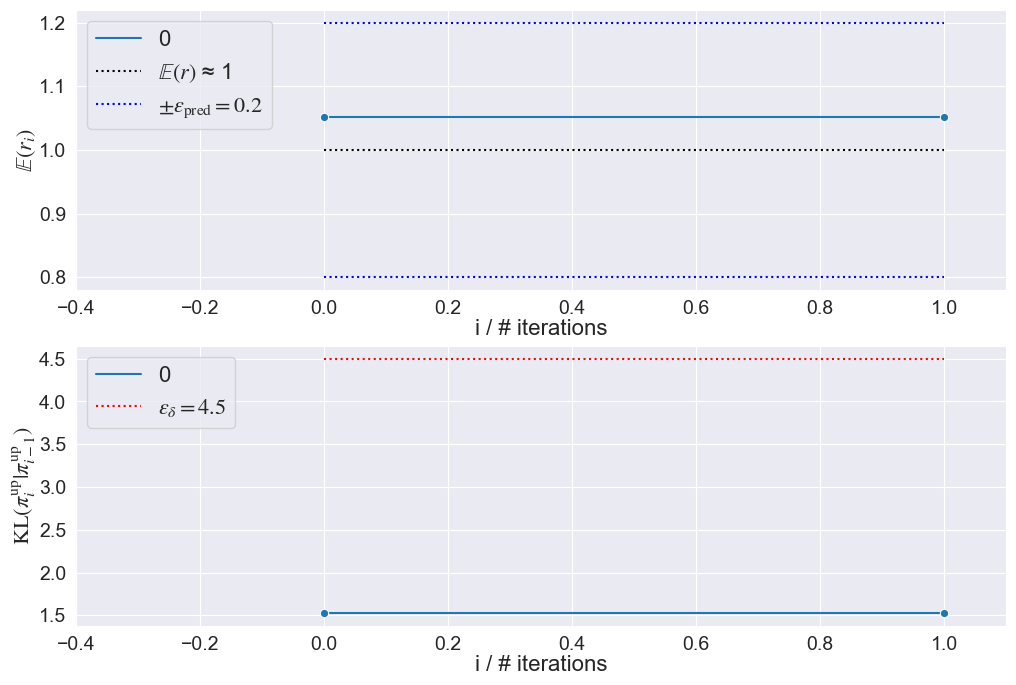

In [32]:
# TODO: Fade-out those that violate criteria?
prob_1.joint_metric_plot()

<AxesSubplot: title={'center': 'Infected Population'}, xlabel='Days', ylabel='Fraction of Population'>

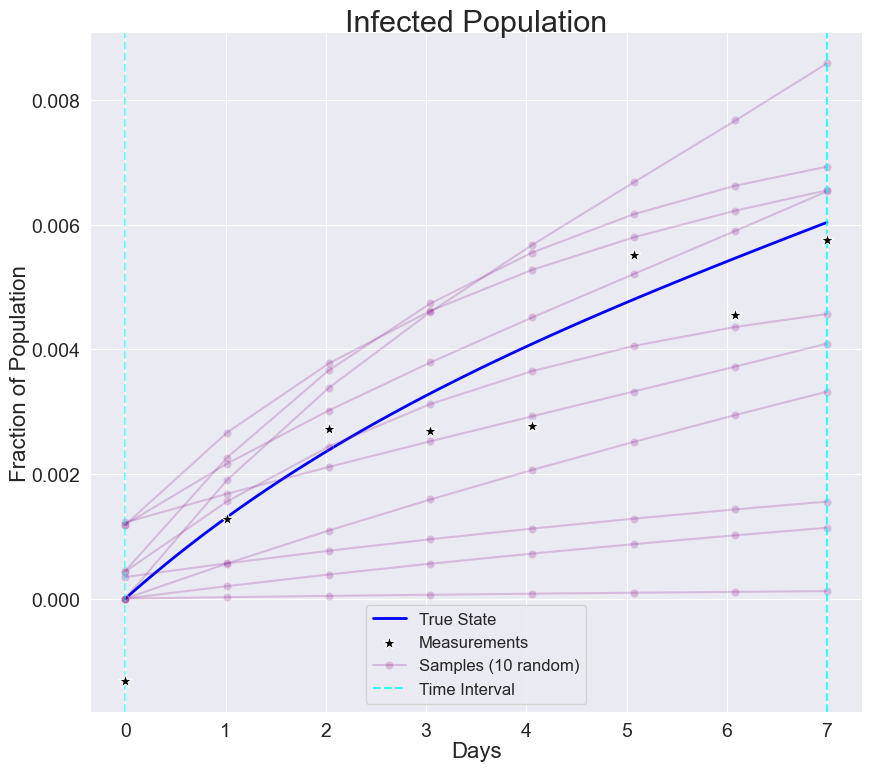

In [33]:
sr.plot_infected()

In [12]:
prob.param_density_plots(search_idxs=[0], lam_true=sr.lam_true)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 prob.param_density_plots(search_idxs=[0], lam_true=sr.lam_true)                              │
│   2                                                                                              │
│                                                                                                  │
│ ╭─────────────────────────────────────────── locals ───────────────────────────────────────────╮ │
│ │                ax = <AxesSubplot: title={'center': 'Infected Population'}, xlabel='Days',    │ │
│ │                     ylabel='Fraction of Population'>                                         │ │
│ │   data_chunk_size = 7                                                                        │ │
│ │       disable_log = <function disable_log at 0x16a4e3880>                                    │ │
│ │        e_r_thresh = 0.1                                                                      │ │
│ │        enable_log = <function enable_log at 0x16a4e37e0>                                     │ │
│ │              exit = <IPython.core.autocall.ZMQExitAutocall object at 0x11080cd50>            │ │
│ │               fig = <Figure size 1500x500 with 1 Axes>                                       │ │
│ │           full_sr = <pydci.examples.seirs.SEIRSModel object at 0x1692187d0>                  │ │
│ │       get_ipython = <bound method InteractiveShell.get_ipython of                            │ │
│ │                     <ipykernel.zmqshell.ZMQInteractiveShell object at 0x110805810>>          │ │
│ │       get_l2_errs = <function get_l2_errs at 0x16a510b80>                                    │ │
│ │         importlib = <module 'importlib' from                                                 │ │
│ │                     '/Users/carlos/.mm/envs/chg-dev/lib/python3.11/importlib/__init__.py'>   │ │
│ │                In = [                                                                        │ │
│ │                     │   '',                                                                  │ │
│ │                     │   'import numpy as np\nimport pandas as pd\nfrom matplotlib import     │ │
│ │                     pyplot as plt\n\nimp'+1692,                                              │ │
│ │                     │   'def solve_till_thresh(\n    model,\n    data_idx,\n                 │ │
│ │                     start_sample_size=100,\n    m'+1468,                                     │ │
│ │                     │   'enable_log(level="DEBUG")\nfull_sr = seirs.SEIRSModel(\n            │ │
│ │                     lam_true=SEIRS_P1,\n   '+436,                                            │ │
│ │                     │   'total_time = 1 * 365.25\nmax_nc = 1\ndata_chunk_size = 7\nn_chunks  │ │
│ │                     = int(total_time'+260,                                                   │ │
│ │                     │   'probs = []\nn_samples = 100\ne_r_thresh = 0.1',                     │ │
│ │                     │   "# enable_log(level='DEBUG')\ndisable_log()\n\ntry:\n                │ │
│ │                     sr.get_data(tf=7)\nexcept Val"+26,                                       │ │
│ │                     │   "enable_log(level='DEBUG', file='test.log')\nprob =                  │ │
│ │                     solve_till_thresh(\n    sr,\n   "+193,                                   │ │
│ │                     │   'prob.search_results',                                               │ │
│ │                     │   '# TODO: No exp threshold on \npd.concat([prob.result for prob in    │ │
│ │                     prob.probs] )',                                                          │ │
│ │                     │   ... +3                           

### Second Iteration

In [13]:
pi_up_1 = prob.best.dists["pi_up"]

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 pi_up_1 = prob.best.dists["pi_up"]                                                           │
│   2                                                                                              │
│                                                                                                  │
│ ╭─────────────────────────────────────────── locals ───────────────────────────────────────────╮ │
│ │                ax = <AxesSubplot: title={'center': 'Infected Population'}, xlabel='Days',    │ │
│ │                     ylabel='Fraction of Population'>                                         │ │
│ │   data_chunk_size = 7                                                                        │ │
│ │       disable_log = <function disable_log at 0x16a4e3880>                                    │ │
│ │        e_r_thresh = 0.1                                                                      │ │
│ │        enable_log = <function enable_log at 0x16a4e37e0>                                     │ │
│ │              exit = <IPython.core.autocall.ZMQExitAutocall object at 0x11080cd50>            │ │
│ │               fig = <Figure size 1500x500 with 1 Axes>                                       │ │
│ │           full_sr = <pydci.examples.seirs.SEIRSModel object at 0x1692187d0>                  │ │
│ │       get_ipython = <bound method InteractiveShell.get_ipython of                            │ │
│ │                     <ipykernel.zmqshell.ZMQInteractiveShell object at 0x110805810>>          │ │
│ │       get_l2_errs = <function get_l2_errs at 0x16a510b80>                                    │ │
│ │         importlib = <module 'importlib' from                                                 │ │
│ │                     '/Users/carlos/.mm/envs/chg-dev/lib/python3.11/importlib/__init__.py'>   │ │
│ │                In = [                                                                        │ │
│ │                     │   '',                                                                  │ │
│ │                     │   'import numpy as np\nimport pandas as pd\nfrom matplotlib import     │ │
│ │                     pyplot as plt\n\nimp'+1692,                                              │ │
│ │                     │   'def solve_till_thresh(\n    model,\n    data_idx,\n                 │ │
│ │                     start_sample_size=100,\n    m'+1468,                                     │ │
│ │                     │   'enable_log(level="DEBUG")\nfull_sr = seirs.SEIRSModel(\n            │ │
│ │                     lam_true=SEIRS_P1,\n   '+436,                                            │ │
│ │                     │   'total_time = 1 * 365.25\nmax_nc = 1\ndata_chunk_size = 7\nn_chunks  │ │
│ │                     = int(total_time'+260,                                                   │ │
│ │                     │   'probs = []\nn_samples = 100\ne_r_thresh = 0.1',                     │ │
│ │                     │   "# enable_log(level='DEBUG')\ndisable_log()\n\ntry:\n                │ │
│ │                     sr.get_data(tf=7)\nexcept Val"+26,                                       │ │
│ │                     │   "enable_log(level='DEBUG', file='test.log')\nprob =                  │ │
│ │                     solve_till_thresh(\n    sr,\n   "+193,                                   │ │
│ │                     │   'prob.search_results',                                               │ │
│ │                     │   '# TODO: No exp threshold on \npd.concat([prob.result for prob in    │ │
│ │                     prob.probs] )',                                                          │ │
│ │                     │   ... +4                           

In [14]:
disable_log()

try:
    sr.get_data(tf=14)
except ValueError as v:
    print(v)

In [15]:
enable_log(level='DEBUG', file='test.log')
prob = solve_till_thresh(
    sr,
    1,
    clear=True,
    start_sample_size=10,
    max_sample_size=200,
    samples_inc=20,
    pi_in=pi_up_1,
    sampling_args={'scale': 1.0},
    solve_args={'exp_thresh': e_r_thresh, 'best_method': 'max_kl'},
)
prob.n_samples

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:9                                                                                    │
│                                                                                                  │
│    6 │   start_sample_size=10,                                                                   │
│    7 │   max_sample_size=200,                                                                    │
│    8 │   samples_inc=20,                                                                         │
│ ❱  9 │   pi_in=pi_up_1,                                                                          │
│   10 │   sampling_args={'scale': 1.0},                                                           │
│   11 │   solve_args={'exp_thresh': e_r_thresh, 'best_method': 'max_kl'},                         │
│   12 )                                                                                           │
│                                                                                                  │
│ ╭─────────────────────────────────────────── locals ───────────────────────────────────────────╮ │
│ │                ax = <AxesSubplot: title={'center': 'Infected Population'}, xlabel='Days',    │ │
│ │                     ylabel='Fraction of Population'>                                         │ │
│ │   data_chunk_size = 7                                                                        │ │
│ │       disable_log = <function disable_log at 0x16a4e3880>                                    │ │
│ │        e_r_thresh = 0.1                                                                      │ │
│ │        enable_log = <function enable_log at 0x16a4e37e0>                                     │ │
│ │              exit = <IPython.core.autocall.ZMQExitAutocall object at 0x11080cd50>            │ │
│ │               fig = <Figure size 1500x500 with 1 Axes>                                       │ │
│ │           full_sr = <pydci.examples.seirs.SEIRSModel object at 0x1692187d0>                  │ │
│ │       get_ipython = <bound method InteractiveShell.get_ipython of                            │ │
│ │                     <ipykernel.zmqshell.ZMQInteractiveShell object at 0x110805810>>          │ │
│ │       get_l2_errs = <function get_l2_errs at 0x16a510b80>                                    │ │
│ │         importlib = <module 'importlib' from                                                 │ │
│ │                     '/Users/carlos/.mm/envs/chg-dev/lib/python3.11/importlib/__init__.py'>   │ │
│ │                In = [                                                                        │ │
│ │                     │   '',                                                                  │ │
│ │                     │   'import numpy as np\nimport pandas as pd\nfrom matplotlib import     │ │
│ │                     pyplot as plt\n\nimp'+1692,                                              │ │
│ │                     │   'def solve_till_thresh(\n    model,\n    data_idx,\n                 │ │
│ │                     start_sample_size=100,\n    m'+1468,                                     │ │
│ │                     │   'enable_log(level="DEBUG")\nfull_sr = seirs.SEIRSModel(\n            │ │
│ │                     lam_true=SEIRS_P1,\n   '+436,                                            │ │
│ │                     │   'total_time = 1 * 365.25\nmax_nc = 1\ndata_chunk_size = 7\nn_chunks  │ │
│ │                     = int(total_time'+260,                                                   │ │
│ │                     │   'probs = []\nn_samples = 100\ne_r_thresh = 0.1',                     │ │
│ │                     │   "# enable_log(level='DEBUG')\ndisable_log()\n\ntry:\n                │ │
│ │                     sr.get_data(tf=7)\nexcept Val"+26,                                       │ │
│ │                     │   "enable_log(level='DEBUG', file='

In [16]:
prob.full_search_results

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 prob.full_search_results                                                                     │
│   2                                                                                              │
│                                                                                                  │
│ ╭─────────────────────────────────────────── locals ───────────────────────────────────────────╮ │
│ │                ax = <AxesSubplot: title={'center': 'Infected Population'}, xlabel='Days',    │ │
│ │                     ylabel='Fraction of Population'>                                         │ │
│ │   data_chunk_size = 7                                                                        │ │
│ │       disable_log = <function disable_log at 0x16a4e3880>                                    │ │
│ │        e_r_thresh = 0.1                                                                      │ │
│ │        enable_log = <function enable_log at 0x16a4e37e0>                                     │ │
│ │              exit = <IPython.core.autocall.ZMQExitAutocall object at 0x11080cd50>            │ │
│ │               fig = <Figure size 1500x500 with 1 Axes>                                       │ │
│ │           full_sr = <pydci.examples.seirs.SEIRSModel object at 0x1692187d0>                  │ │
│ │       get_ipython = <bound method InteractiveShell.get_ipython of                            │ │
│ │                     <ipykernel.zmqshell.ZMQInteractiveShell object at 0x110805810>>          │ │
│ │       get_l2_errs = <function get_l2_errs at 0x16a510b80>                                    │ │
│ │         importlib = <module 'importlib' from                                                 │ │
│ │                     '/Users/carlos/.mm/envs/chg-dev/lib/python3.11/importlib/__init__.py'>   │ │
│ │                In = [                                                                        │ │
│ │                     │   '',                                                                  │ │
│ │                     │   'import numpy as np\nimport pandas as pd\nfrom matplotlib import     │ │
│ │                     pyplot as plt\n\nimp'+1692,                                              │ │
│ │                     │   'def solve_till_thresh(\n    model,\n    data_idx,\n                 │ │
│ │                     start_sample_size=100,\n    m'+1468,                                     │ │
│ │                     │   'enable_log(level="DEBUG")\nfull_sr = seirs.SEIRSModel(\n            │ │
│ │                     lam_true=SEIRS_P1,\n   '+436,                                            │ │
│ │                     │   'total_time = 1 * 365.25\nmax_nc = 1\ndata_chunk_size = 7\nn_chunks  │ │
│ │                     = int(total_time'+260,                                                   │ │
│ │                     │   'probs = []\nn_samples = 100\ne_r_thresh = 0.1',                     │ │
│ │                     │   "# enable_log(level='DEBUG')\ndisable_log()\n\ntry:\n                │ │
│ │                     sr.get_data(tf=7)\nexcept Val"+26,                                       │ │
│ │                     │   "enable_log(level='DEBUG', file='test.log')\nprob =                  │ │
│ │                     solve_till_thresh(\n    sr,\n   "+193,                                   │ │
│ │                     │   'prob.search_results',                                               │ │
│ │                     │   '# TODO: No exp threshold on \npd.concat([prob.result for prob in    │ │
│ │                     prob.probs] )',                                                          │ │
│ │                     │   ... +7                           

In [17]:
# TODO: Fade-out those that violate criteria?
prob.joint_metric_plot()

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│   1 # TODO: Fade-out those that violate criteria?                                                │
│ ❱ 2 prob.joint_metric_plot()                                                                     │
│   3                                                                                              │
│                                                                                                  │
│ ╭─────────────────────────────────────────── locals ───────────────────────────────────────────╮ │
│ │                ax = <AxesSubplot: title={'center': 'Infected Population'}, xlabel='Days',    │ │
│ │                     ylabel='Fraction of Population'>                                         │ │
│ │   data_chunk_size = 7                                                                        │ │
│ │       disable_log = <function disable_log at 0x16a4e3880>                                    │ │
│ │        e_r_thresh = 0.1                                                                      │ │
│ │        enable_log = <function enable_log at 0x16a4e37e0>                                     │ │
│ │              exit = <IPython.core.autocall.ZMQExitAutocall object at 0x11080cd50>            │ │
│ │               fig = <Figure size 1500x500 with 1 Axes>                                       │ │
│ │           full_sr = <pydci.examples.seirs.SEIRSModel object at 0x1692187d0>                  │ │
│ │       get_ipython = <bound method InteractiveShell.get_ipython of                            │ │
│ │                     <ipykernel.zmqshell.ZMQInteractiveShell object at 0x110805810>>          │ │
│ │       get_l2_errs = <function get_l2_errs at 0x16a510b80>                                    │ │
│ │         importlib = <module 'importlib' from                                                 │ │
│ │                     '/Users/carlos/.mm/envs/chg-dev/lib/python3.11/importlib/__init__.py'>   │ │
│ │                In = [                                                                        │ │
│ │                     │   '',                                                                  │ │
│ │                     │   'import numpy as np\nimport pandas as pd\nfrom matplotlib import     │ │
│ │                     pyplot as plt\n\nimp'+1692,                                              │ │
│ │                     │   'def solve_till_thresh(\n    model,\n    data_idx,\n                 │ │
│ │                     start_sample_size=100,\n    m'+1468,                                     │ │
│ │                     │   'enable_log(level="DEBUG")\nfull_sr = seirs.SEIRSModel(\n            │ │
│ │                     lam_true=SEIRS_P1,\n   '+436,                                            │ │
│ │                     │   'total_time = 1 * 365.25\nmax_nc = 1\ndata_chunk_size = 7\nn_chunks  │ │
│ │                     = int(total_time'+260,                                                   │ │
│ │                     │   'probs = []\nn_samples = 100\ne_r_thresh = 0.1',                     │ │
│ │                     │   "# enable_log(level='DEBUG')\ndisable_log()\n\ntry:\n                │ │
│ │                     sr.get_data(tf=7)\nexcept Val"+26,                                       │ │
│ │                     │   "enable_log(level='DEBUG', file='test.log')\nprob =                  │ │
│ │                     solve_till_thresh(\n    sr,\n   "+193,                                   │ │
│ │                     │   'prob.search_results',                                               │ │
│ │                     │   '# TODO: No exp threshold on \npd.concat([prob.result for prob in    │ │
│ │                     prob.probs] )',                      

In [18]:
prob.param_density_plots(search_idxs=[0], lam_true=sr.lam_true)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 prob.param_density_plots(search_idxs=[0], lam_true=sr.lam_true)                              │
│   2                                                                                              │
│                                                                                                  │
│ ╭─────────────────────────────────────────── locals ───────────────────────────────────────────╮ │
│ │                ax = <AxesSubplot: title={'center': 'Infected Population'}, xlabel='Days',    │ │
│ │                     ylabel='Fraction of Population'>                                         │ │
│ │   data_chunk_size = 7                                                                        │ │
│ │       disable_log = <function disable_log at 0x16a4e3880>                                    │ │
│ │        e_r_thresh = 0.1                                                                      │ │
│ │        enable_log = <function enable_log at 0x16a4e37e0>                                     │ │
│ │              exit = <IPython.core.autocall.ZMQExitAutocall object at 0x11080cd50>            │ │
│ │               fig = <Figure size 1500x500 with 1 Axes>                                       │ │
│ │           full_sr = <pydci.examples.seirs.SEIRSModel object at 0x1692187d0>                  │ │
│ │       get_ipython = <bound method InteractiveShell.get_ipython of                            │ │
│ │                     <ipykernel.zmqshell.ZMQInteractiveShell object at 0x110805810>>          │ │
│ │       get_l2_errs = <function get_l2_errs at 0x16a510b80>                                    │ │
│ │         importlib = <module 'importlib' from                                                 │ │
│ │                     '/Users/carlos/.mm/envs/chg-dev/lib/python3.11/importlib/__init__.py'>   │ │
│ │                In = [                                                                        │ │
│ │                     │   '',                                                                  │ │
│ │                     │   'import numpy as np\nimport pandas as pd\nfrom matplotlib import     │ │
│ │                     pyplot as plt\n\nimp'+1692,                                              │ │
│ │                     │   'def solve_till_thresh(\n    model,\n    data_idx,\n                 │ │
│ │                     start_sample_size=100,\n    m'+1468,                                     │ │
│ │                     │   'enable_log(level="DEBUG")\nfull_sr = seirs.SEIRSModel(\n            │ │
│ │                     lam_true=SEIRS_P1,\n   '+436,                                            │ │
│ │                     │   'total_time = 1 * 365.25\nmax_nc = 1\ndata_chunk_size = 7\nn_chunks  │ │
│ │                     = int(total_time'+260,                                                   │ │
│ │                     │   'probs = []\nn_samples = 100\ne_r_thresh = 0.1',                     │ │
│ │                     │   "# enable_log(level='DEBUG')\ndisable_log()\n\ntry:\n                │ │
│ │                     sr.get_data(tf=7)\nexcept Val"+26,                                       │ │
│ │                     │   "enable_log(level='DEBUG', file='test.log')\nprob =                  │ │
│ │                     solve_till_thresh(\n    sr,\n   "+193,                                   │ │
│ │                     │   'prob.search_results',                                               │ │
│ │                     │   '# TODO: No exp threshold on \npd.concat([prob.result for prob in    │ │
│ │                     prob.probs] )',                                                          │ │
│ │                     │   ... +9                           

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 sr.plot_infected()                                                                           │
│   2                                                                                              │
│                                                                                                  │
│ ╭─────────────────────────────────────────── locals ───────────────────────────────────────────╮ │
│ │                ax = <AxesSubplot: title={'center': 'Infected Population'}, xlabel='Days',    │ │
│ │                     ylabel='Fraction of Population'>                                         │ │
│ │   data_chunk_size = 7                                                                        │ │
│ │       disable_log = <function disable_log at 0x16a4e3880>                                    │ │
│ │        e_r_thresh = 0.1                                                                      │ │
│ │        enable_log = <function enable_log at 0x16a4e37e0>                                     │ │
│ │              exit = <IPython.core.autocall.ZMQExitAutocall object at 0x11080cd50>            │ │
│ │               fig = <Figure size 1500x500 with 1 Axes>                                       │ │
│ │           full_sr = <pydci.examples.seirs.SEIRSModel object at 0x1692187d0>                  │ │
│ │       get_ipython = <bound method InteractiveShell.get_ipython of                            │ │
│ │                     <ipykernel.zmqshell.ZMQInteractiveShell object at 0x110805810>>          │ │
│ │       get_l2_errs = <function get_l2_errs at 0x16a510b80>                                    │ │
│ │         importlib = <module 'importlib' from                                                 │ │
│ │                     '/Users/carlos/.mm/envs/chg-dev/lib/python3.11/importlib/__init__.py'>   │ │
│ │                In = [                                                                        │ │
│ │                     │   '',                                                                  │ │
│ │                     │   'import numpy as np\nimport pandas as pd\nfrom matplotlib import     │ │
│ │                     pyplot as plt\n\nimp'+1692,                                              │ │
│ │                     │   'def solve_till_thresh(\n    model,\n    data_idx,\n                 │ │
│ │                     start_sample_size=100,\n    m'+1468,                                     │ │
│ │                     │   'enable_log(level="DEBUG")\nfull_sr = seirs.SEIRSModel(\n            │ │
│ │                     lam_true=SEIRS_P1,\n   '+436,                                            │ │
│ │                     │   'total_time = 1 * 365.25\nmax_nc = 1\ndata_chunk_size = 7\nn_chunks  │ │
│ │                     = int(total_time'+260,                                                   │ │
│ │                     │   'probs = []\nn_samples = 100\ne_r_thresh = 0.1',                     │ │
│ │                     │   "# enable_log(level='DEBUG')\ndisable_log()\n\ntry:\n                │ │
│ │                     sr.get_data(tf=7)\nexcept Val"+26,                                       │ │
│ │                     │   "enable_log(level='DEBUG', file='test.log')\nprob =                  │ │
│ │                     solve_till_thresh(\n    sr,\n   "+193,                                   │ │
│ │                     │   'prob.search_results',                                               │ │
│ │                     │   '# TODO: No exp threshold on \npd.concat([prob.result for prob in    │ │
│ │                     prob.probs] )',                                                          │ │
│ │                     │   ... +10                          

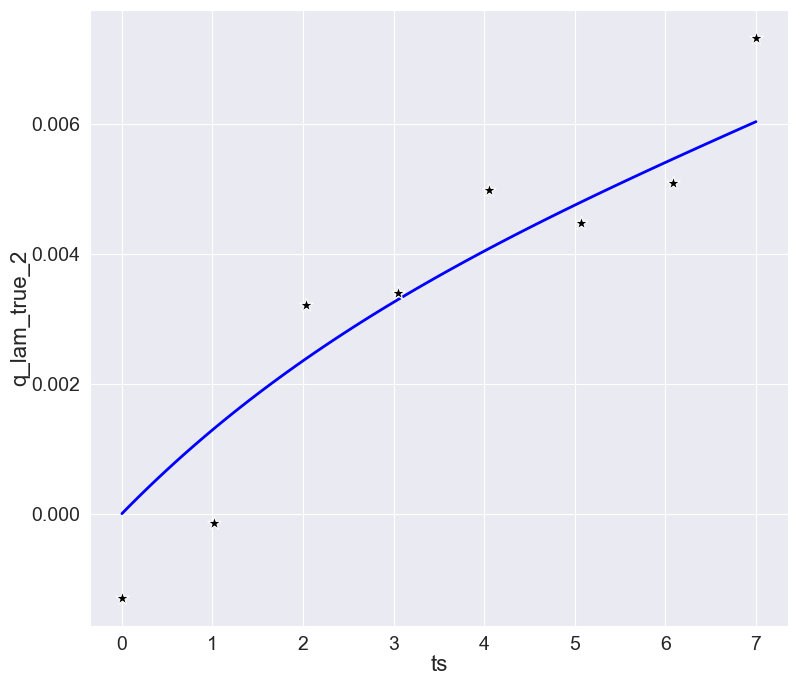

In [19]:
sr.plot_infected()

### Third Iteration

In [ ]:
samples = best[1].sample_dist(num_samples=n_samples)

Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (6131.


<AxesSubplot: title={'center': 'Infected Population'}, xlabel='Days', ylabel='Fraction of Population'>

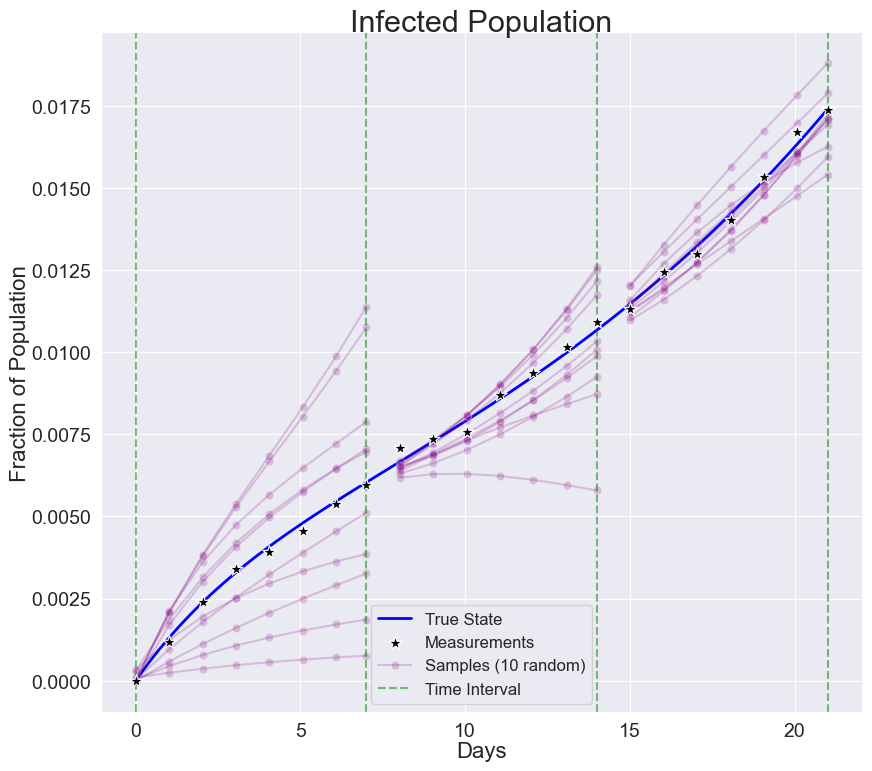

In [ ]:
sr.get_data(3 * n_weeks * 7)
sr.forward_solve(samples)
sr.plot_infected()

In [ ]:
search_combs = sr.get_search_combinations(
    max_nc=max_nc, data_chunk_size=data_chunk_size
)
pd.DataFrame(search_combs)

,exp_thresh,pca_components,pca_mask,pca_splits
0,1.000000e+10,[[0]],"(0, 1, 2, 3, 4, 5, 6)",1
1,1.000000e+10,"[[0, 1]]","(0, 1, 2, 3, 4, 5, 6)",1
2,1.000000e+10,"[[0, 1, 2]]","(0, 1, 2, 3, 4, 5, 6)",1


In [ ]:
disable_log()
res_3 = sr.solve_search(search_combs, exp_thresh=0.5, best_method="max_kl", pi_in=pi_in)
search_res_3 = get_l2_errs(res_3["search_results"], SEIRS_P1)
best.append(res_3["best"])
search_res_3

Solving for different combinations |████████████████████████████████████████| 3/


,e_r,kl,lam_MUD_0,lam_MUD_1,lam_MUD_2,lam_MUD_3,MUD_idx,pca_components,pca_mask,i,index,predict_delta,within_thresh,closest,max_kl,min_kl,l2_err,rel_err
0,1.056461,1.048761,0.205307,0.136466,0.065253,0.006360,19,[0],"range(0, 7)",0,0,0.056461,True,False,False,True,0.013142,0.049169
0,1.130793,1.682465,0.222689,0.125593,0.059344,0.002354,727,"[0, 1]","range(0, 7)",0,1,0.130793,True,False,False,False,0.022690,0.084895
0,0.973798,1.747766,0.133617,0.117060,0.025240,0.002020,752,"[0, 1, 2]","range(0, 7)",0,2,0.026202,True,True,True,False,0.096472,0.360946


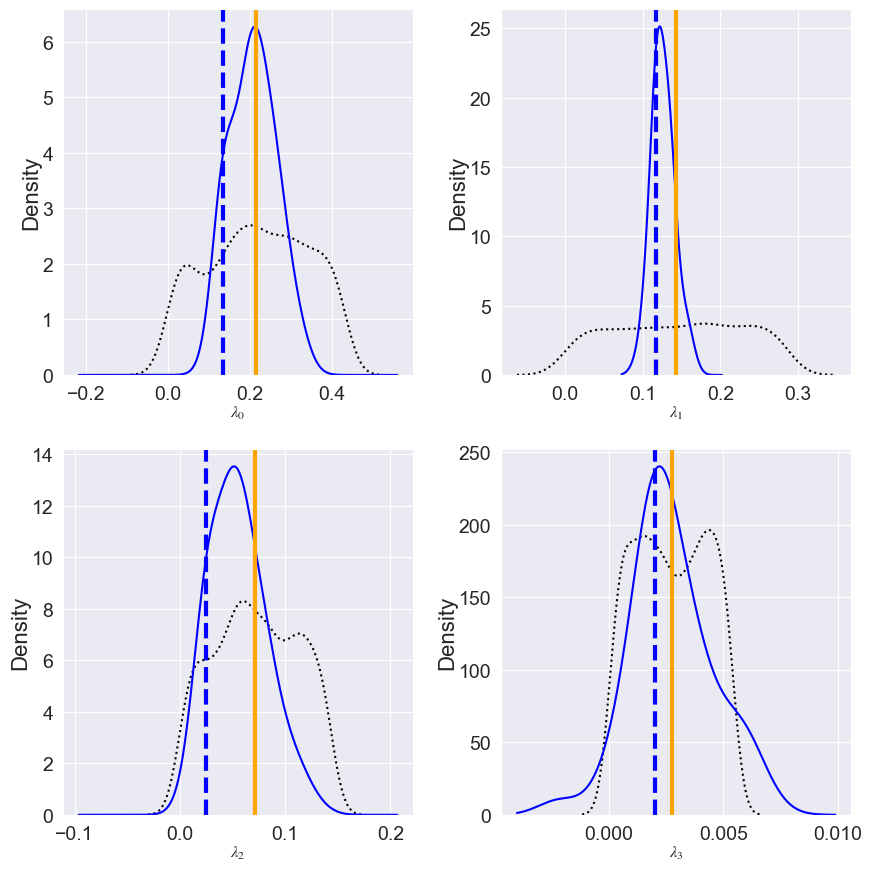

In [ ]:
plot_iterations(best, lam_true=[SEIRS_P1])

### Fourth Iteration -> Shift

In [ ]:
samples = best[2].sample_dist(num_samples=n_samples)

Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (5899.


<AxesSubplot: title={'center': 'Infected Population'}, xlabel='Days', ylabel='Fraction of Population'>

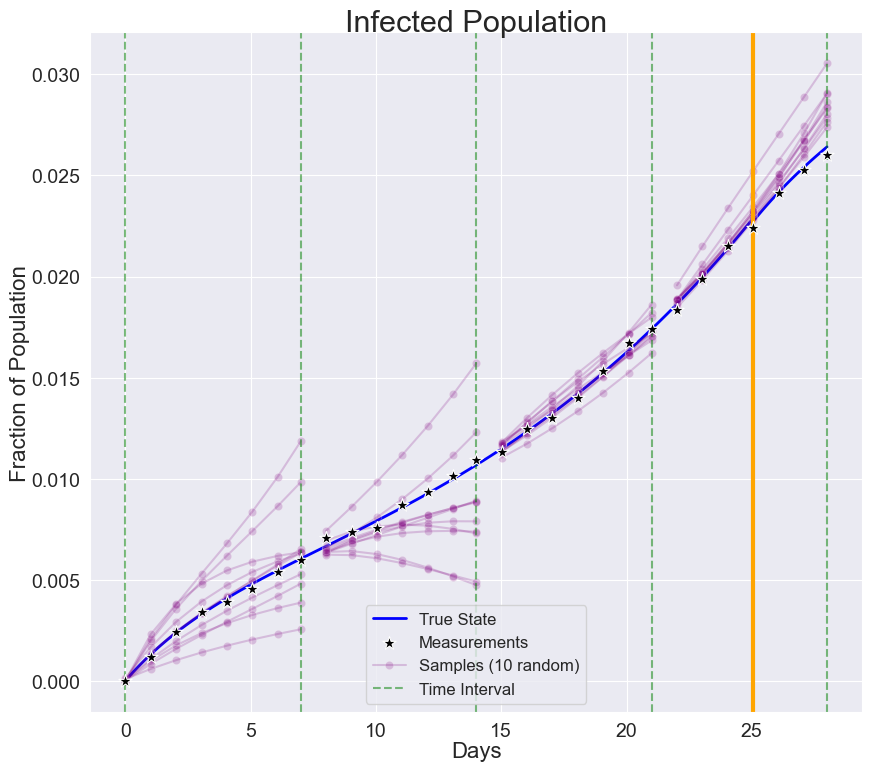

In [ ]:
sr.get_data(4 * n_weeks * 7)
sr.forward_solve(samples)
sr.plot_infected()

In [ ]:
search_combs = sr.get_search_combinations(
    max_nc=max_nc, data_chunk_size=data_chunk_size
)
pd.DataFrame(search_combs)

,exp_thresh,pca_components,pca_mask,pca_splits
0,1.000000e+10,[[0]],"(0, 1, 2, 3, 4, 5, 6)",1
1,1.000000e+10,"[[0, 1]]","(0, 1, 2, 3, 4, 5, 6)",1
2,1.000000e+10,"[[0, 1, 2]]","(0, 1, 2, 3, 4, 5, 6)",1


In [ ]:
disable_log()
res_4 = sr.solve_search(search_combs, exp_thresh=0.5, best_method="max_kl", pi_in=pi_in)
search_res_4 = get_l2_errs(res_4["search_results"], SEIRS_P1)
best.append(res_4["best"])

Solving for different combinations |████████████████████████████████████████| 3/


In [ ]:
search_res_4

,e_r,kl,lam_MUD_0,lam_MUD_1,lam_MUD_2,lam_MUD_3,MUD_idx,pca_components,pca_mask,i,index,predict_delta,within_thresh,closest,max_kl,min_kl,l2_err,rel_err
0,0.944136,3.011576,0.191607,0.110373,0.045725,0.006332,486,[0],"range(0, 7)",0,0,0.055864,True,True,True,True,0.047362,0.177202
0,0.022512,8.512823,0.256762,0.164529,0.111781,0.004121,369,"[0, 1]","range(0, 7)",0,1,0.977488,False,False,False,False,0.062483,0.233779
0,0.000004,7.216180,0.235575,0.157362,0.094580,0.007446,787,"[0, 1, 2]","range(0, 7)",0,2,0.999996,False,False,False,False,0.034954,0.130777


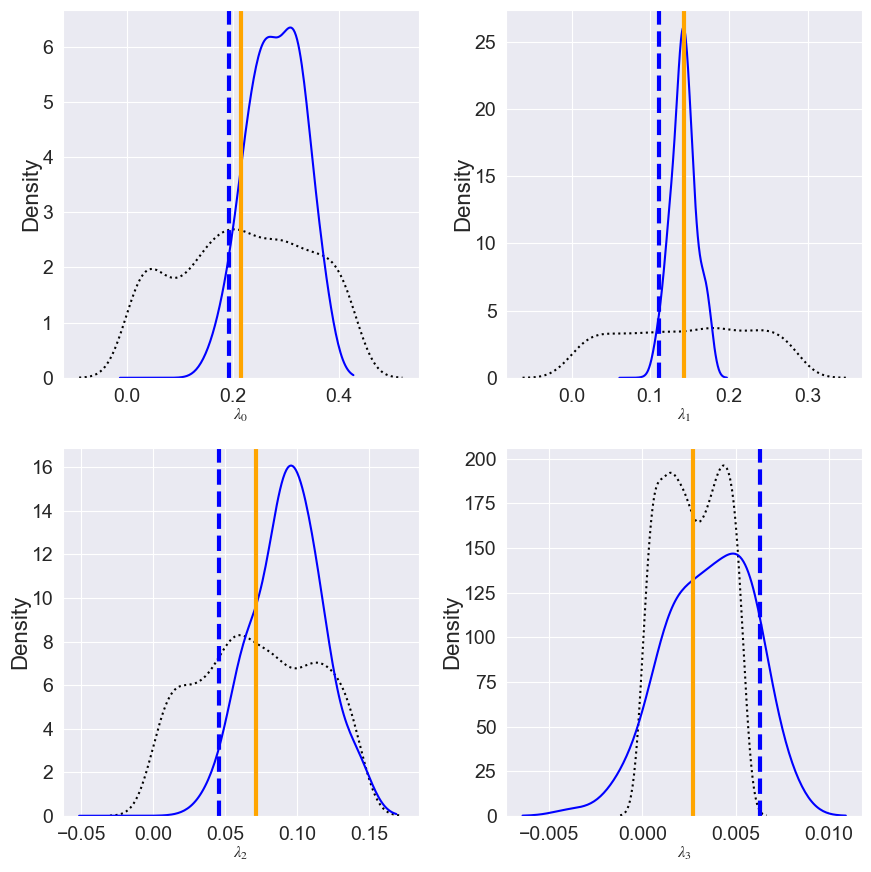

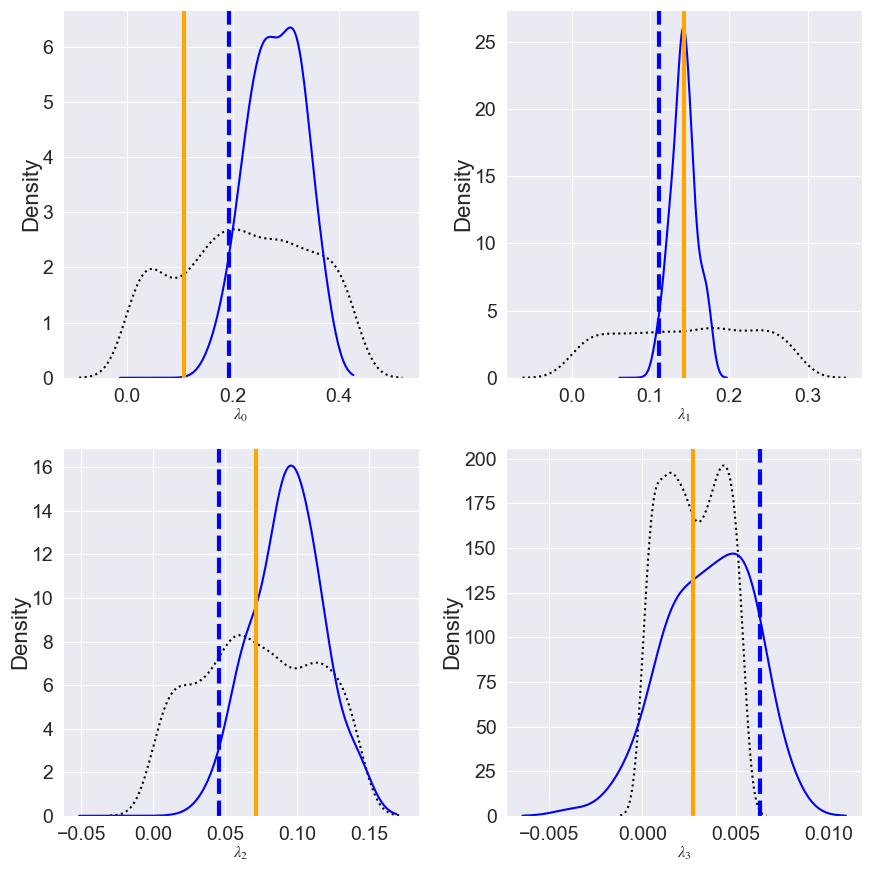

In [ ]:
# TODO: Improve thie plot to show both shifts on same param plots
plot_iterations(best, lam_true=[SEIRS_P1])
plot_iterations(best, lam_true=[SEIRS_P2])

### Fifth Iteration

In [ ]:
samples = best[3].sample_dist(num_samples=n_samples)

Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (4271.


<AxesSubplot: title={'center': 'Infected Population'}, xlabel='Days', ylabel='Fraction of Population'>

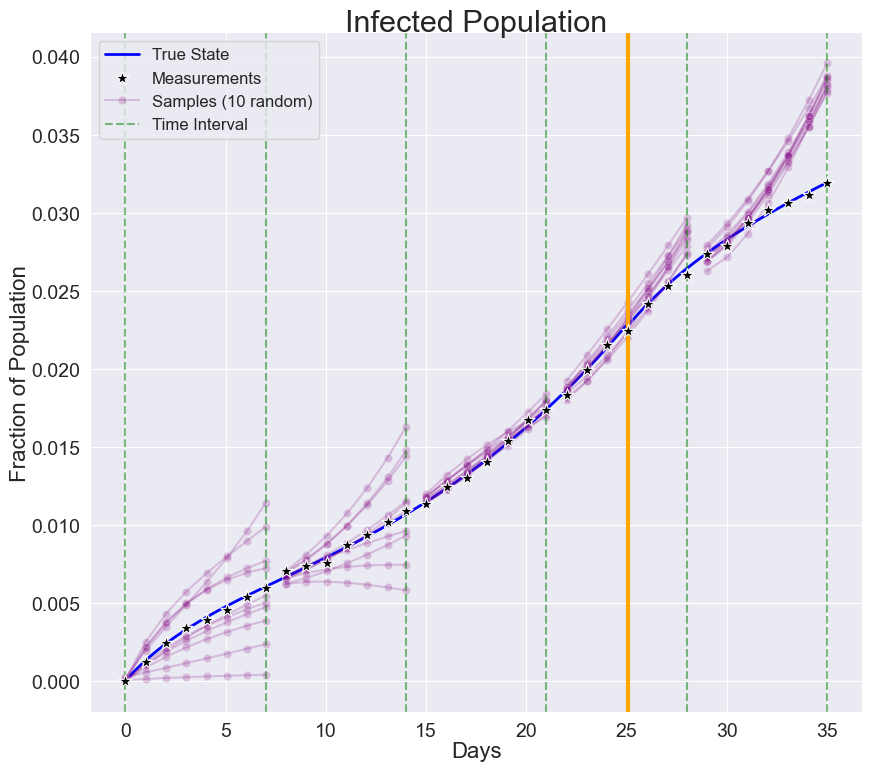

In [ ]:
sr.get_data(5 * n_weeks * 7)
sr.forward_solve(samples)
sr.plot_infected()

In [ ]:
search_combs = sr.get_search_combinations(
    max_nc=max_nc, data_chunk_size=data_chunk_size
)
pd.DataFrame(search_combs)

,exp_thresh,pca_components,pca_mask,pca_splits
0,1.000000e+10,[[0]],"(0, 1, 2, 3, 4, 5, 6)",1
1,1.000000e+10,"[[0, 1]]","(0, 1, 2, 3, 4, 5, 6)",1
2,1.000000e+10,"[[0, 1, 2]]","(0, 1, 2, 3, 4, 5, 6)",1


In [ ]:
disable_log()
res_5 = sr.solve_search(search_combs, exp_thresh=0.5, best_method="max_kl", pi_in=pi_in)
search_res_5 = get_l2_errs(res_5["search_results"], SEIRS_P1)
best.append(res_5["best"])

Solving for different combinations |████████████████████████████████████████| 3/


In [ ]:
search_res_5

,e_r,kl,lam_MUD_0,lam_MUD_1,lam_MUD_2,lam_MUD_3,MUD_idx,pca_components,pca_mask,i,index,predict_delta,within_thresh,closest,max_kl,min_kl,l2_err,rel_err
0,5.847788e-16,11.215081,0.278968,0.168295,0.121212,0.004128,454,[0],"range(0, 7)",0,0,1.0,False,False,False,False,0.085506,0.319916
0,1.644582e-124,9.866095,0.269825,0.161706,0.114015,0.002475,203,"[0, 1]","range(0, 7)",0,1,1.0,False,False,False,False,0.072481,0.271186
0,2.732573e-126,9.201269,0.269825,0.161706,0.114015,0.002475,203,"[0, 1, 2]","range(0, 7)",0,2,1.0,False,False,False,False,0.072481,0.271186


### Fifth Iteation - Retrying

Retry chunk, but reset to initial distribution.


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (6647.


<AxesSubplot: title={'center': 'Infected Population'}, xlabel='Days', ylabel='Fraction of Population'>

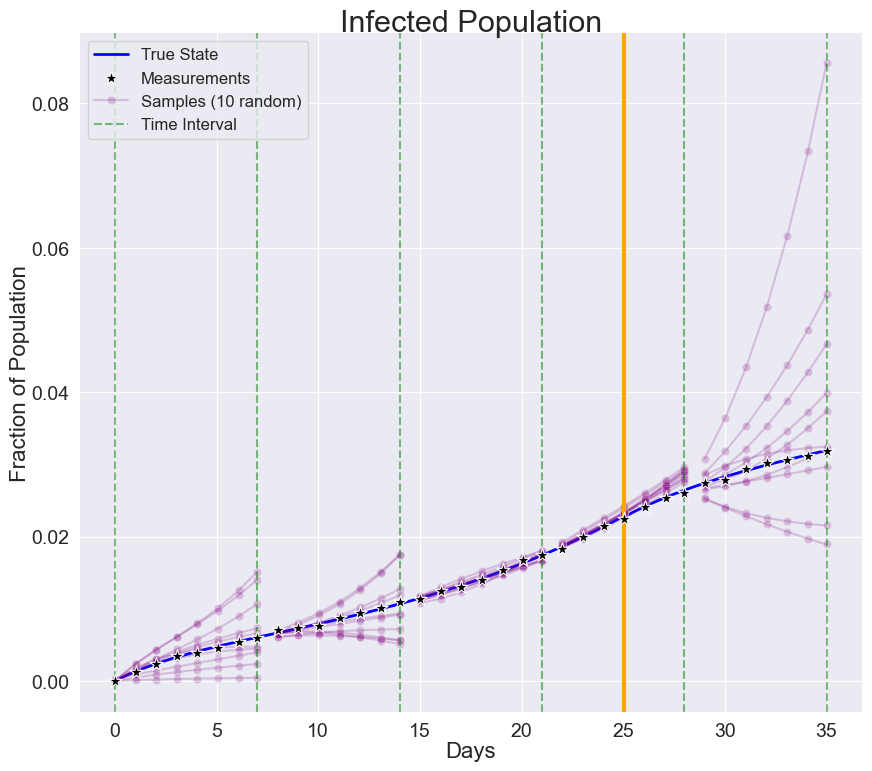

In [ ]:
pi_in, samples = sr.get_uniform_initial_samples(num_samples=n_samples, scale=1.0)
sr.forward_solve(samples)
sr.plot_infected()

In [ ]:
search_combs = sr.get_search_combinations(
    max_nc=max_nc, data_chunk_size=data_chunk_size
)
pd.DataFrame(search_combs)

,exp_thresh,pca_components,pca_mask,pca_splits
0,1.000000e+10,[[0]],"(0, 1, 2, 3, 4, 5, 6)",1
1,1.000000e+10,"[[0, 1]]","(0, 1, 2, 3, 4, 5, 6)",1
2,1.000000e+10,"[[0, 1, 2]]","(0, 1, 2, 3, 4, 5, 6)",1


In [ ]:
disable_log()
res_5 = sr.solve_search(search_combs, exp_thresh=0.5, best_method="max_kl", pi_in=pi_in)
search_res_5 = get_l2_errs(res_5["search_results"], SEIRS_P1)
best.append(res_5["best"])

Solving for different combinations |████████████████████████████████████████| 3/


In [ ]:
search_res_5

,e_r,kl,lam_MUD_0,lam_MUD_1,lam_MUD_2,lam_MUD_3,MUD_idx,pca_components,pca_mask,i,index,predict_delta,within_thresh,closest,max_kl,min_kl,l2_err,rel_err
0,1.201652,3.707657,0.070814,0.099673,0.041858,0.001024,602,[0],"range(0, 7)",0,0,0.201652,True,True,False,True,0.15273,0.571433
0,1.675196,6.133261,0.070814,0.099673,0.041858,0.001024,602,"[0, 1]","range(0, 7)",0,1,0.675196,False,False,False,False,0.15273,0.571433
0,1.281728,5.935910,0.070814,0.099673,0.041858,0.001024,602,"[0, 1, 2]","range(0, 7)",0,2,0.281728,True,False,True,False,0.15273,0.571433


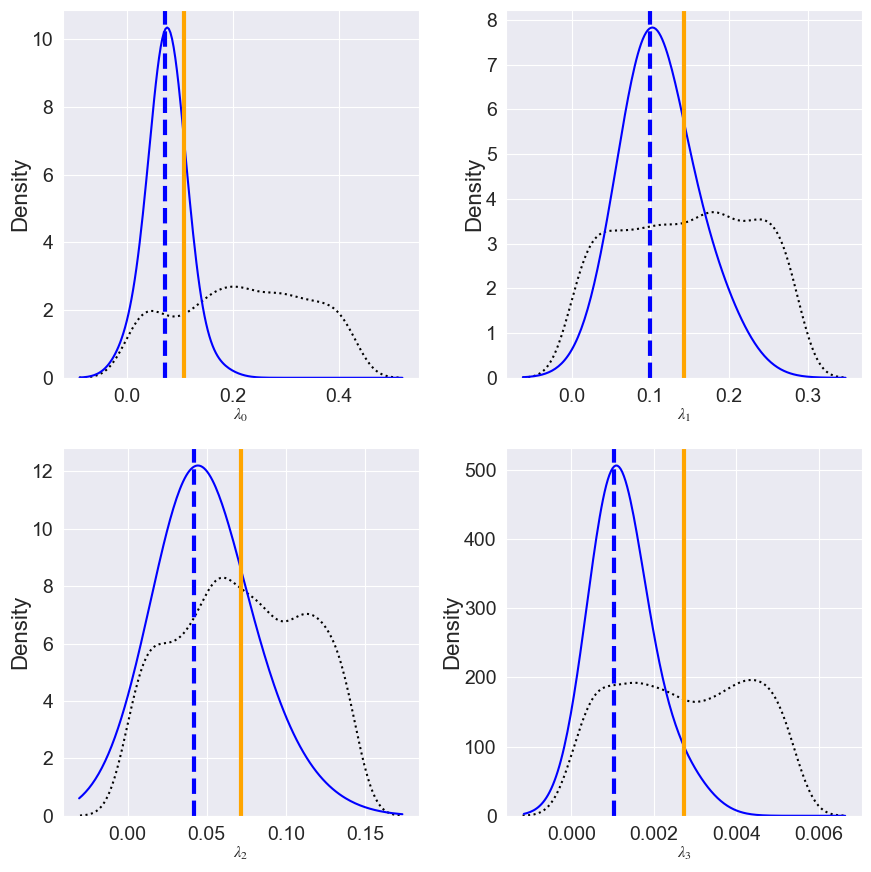

In [ ]:
plot_iterations(best, lam_true=[SEIRS_P2])